In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import f_class
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
objective = f_class.sin(Noise, Noise_level)
# objective = f_class.Ackley_1(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, 1)

clean_f = lambda x: f_class.sin().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=1).func(x)
# clean_f = lambda x: f_class.Ackley_1().func(x)


B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
lb = B[:, 0]; ub = B[:, 1]

f = objective.func
print(f( np.array([2]) ))

dim = objective.input_dim
print('dim: ', dim)

[[0.90929743]]
dim:  1


In [4]:
B

array([[-1., 15.]])

In [4]:
# max budget for finding good point
Budget = 100

In [5]:
# set seed
seed = 1
def draw(n_random_draws=3):
    X = np.random.uniform(lb, ub, size=(n_random_draws, dim))
    return X, f(X)

def optimize_hyper(lb, ub, sample_size=200):
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# find optimized hyper
# gp = GP_grad(B, Noise, Noise_level, compress=False)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

In [9]:
gp = GP_grad(B, Noise, Noise_level, compress=True)

# set optimized hyper
# gp.set_hyper(ls, var)

# put in some random data (let them to be close)
init_size = 4
X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))

# X = np.zeros((init_size, dim))

# sample from a small 2d box
# Xc = np.random.uniform(lb, ub, size=(1, dim))

# X[0] = Xc
# for i in range(1, init_size):
#     X[i] = Xc + 0.5*np.random.uniform(-1, 1, Xc.shape)

gp.set_data(X, f(X))
gp.optimize()
gp.fit()
gp.get_hyper()

{'var': 0.8875549360856008, 'lengthscale': 1.0}

In [11]:
gp._normal(f(X)), gp.posterior(X)

(array([[ 0.70098107],
        [-1.71119279],
        [ 0.31778139],
        [ 0.69243033]]),
 (array([[ 0.70098102],
         [-1.71119277],
         [ 0.31778139],
         [ 0.69243037]]),
  array([[ 9.99990957e-09, -7.45931095e-16,  6.55031585e-15,
           8.63753513e-14],
         [-7.45931095e-16,  9.99999994e-09,  8.32667268e-17,
           6.93889390e-16],
         [ 6.55031585e-15,  8.32667268e-17,  9.99999938e-09,
          -5.77315973e-15],
         [ 8.63753513e-14,  6.93889390e-16, -5.77315973e-15,
           9.99991767e-09]])))

In [12]:
gp.get_hyper()

{'var': 0.8875549360856008, 'lengthscale': 1.0}

In [13]:
# Grid -> test points for plotting
n_Grid = 500
Grid = np.linspace(lb, ub, n_Grid).reshape(-1, dim)

mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

Kt = gp.cov_RBF(Grid, Grid, gp.get_hyper())
K_11 = gp.K11(Grid)
K_01 = gp.K01(Grid)

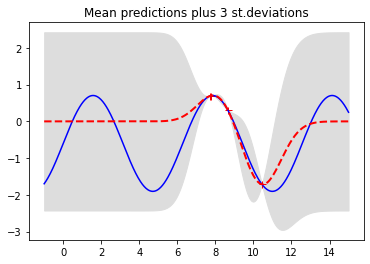

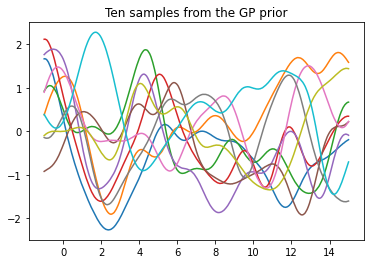

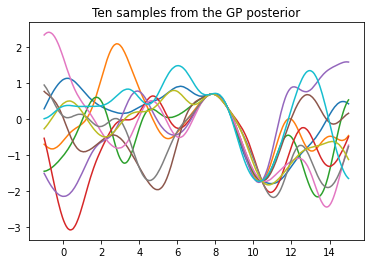

In [17]:
# plot
pl.figure(1)
pl.clf()
pl.plot(gp._X, gp._y, 'r+', ms=7)
pl.plot(Grid, gp._normal(clean_f(Grid)), 'b-')
pl.gca().fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

pl.plot(Grid, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP prior')
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1, 1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP posterior')
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [18]:
mu_grad, covar_grad = gp.posterior_grad(Grid)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [19]:
from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

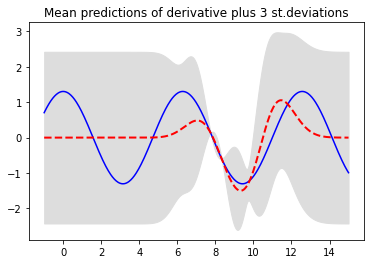

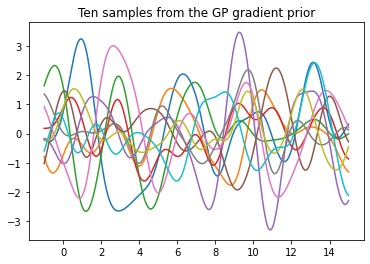

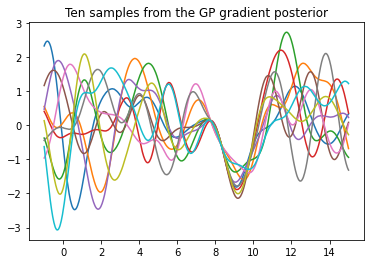

In [21]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(Grid, gp._normal_grad(approx_grad), 'b-')
pl.gca().fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

pl.plot(Grid, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient Descent 

In [22]:
n_iter = 40
lr = 0.1
lr_init = 15
alpha = 0.5

history = []
history_lr = []


w = X[0]
# arg_min = np.argmin(f(X))
# w = X[arg_min] # min value to start
w

array([7.78101606])

In [24]:
def grad(gp, x): # input a fit gp, find the gradient at x
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return m1.reshape(-1, 1)

def grad_sample(gp, x):
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return np.random.normal(m1.item(), s1.item(), 1).reshape((-1, 1))


grad(gp, w), grad_sample(gp, w), gp._normal_grad(optimize.approx_fprime(w, lambda x: clean_f(x).item(), eps) )

(array([[0.10391402]]), array([[0.13827399]]), array([0.09512932]))

In [26]:
gp.posterior(w), gp._normal(clean_f(w))
# gp.posterior_grad(w), gp._normal_grad(optimize.approx_fprime(w, lambda x: clean_f(x).item(), eps) )

((array([[0.70098102]]), array([[9.99990957e-09]])), array([[0.70098107]]))

In [27]:
# approximated grad on mesh points
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

In [28]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
lr = 0.01
mt = np.array([0])
vt = np.array([0])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

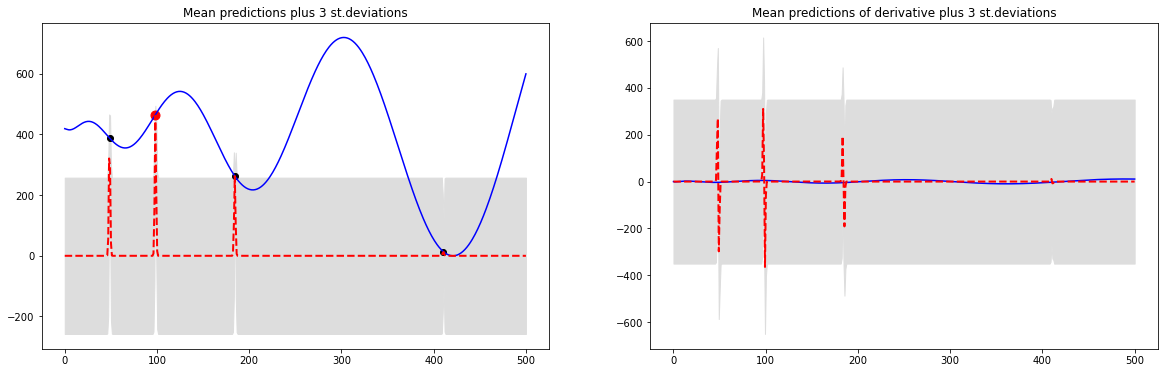

w:  [[112.41638952]]
lr:  0.1
df: [[-9.67086407e-77]], s.d. [[18487.71634552]]
actual df [2.95358276]
  # Optimal (ls, var) =  (0.5142203340855258, 10000.0)


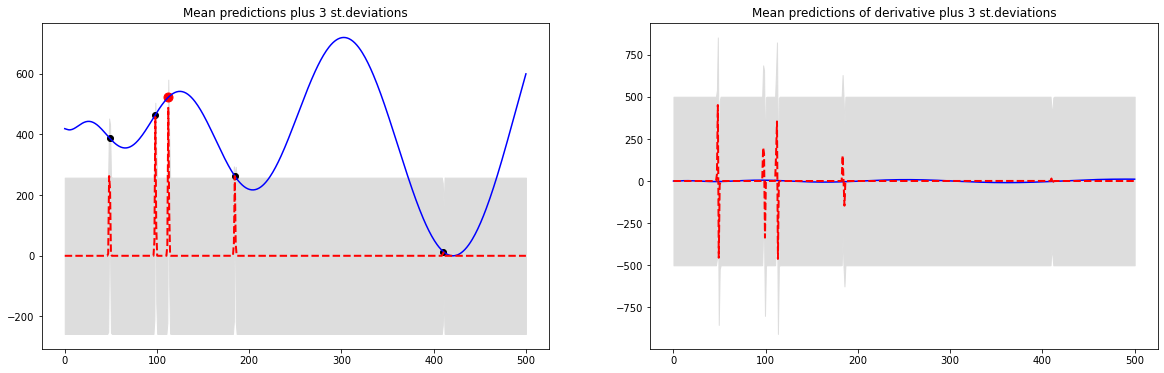

w:  [[98.59928634]]
lr:  0.1
df: [[-452.97550059]], s.d. [[28336.51662944]]
actual df [4.82901382]


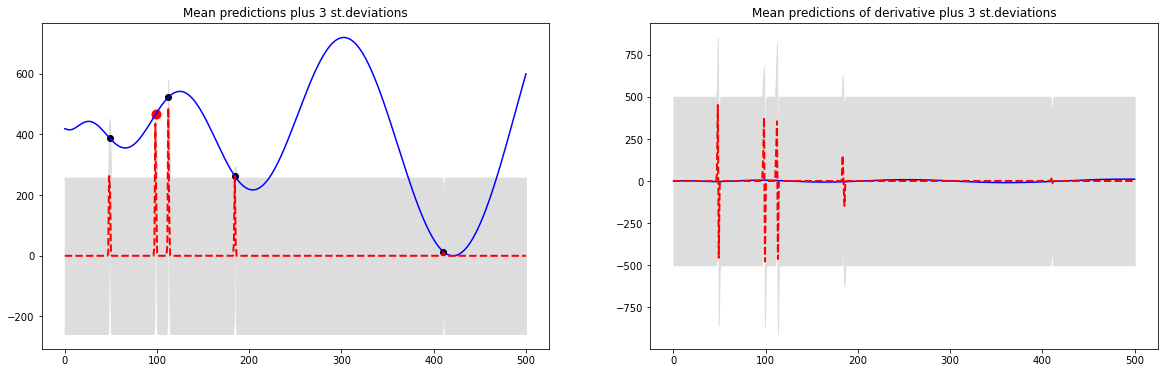

w:  [[124.71024985]]
lr:  0.1
df: [[-1.85539931e-120]], s.d. [[37818.25689547]]
actual df [0.03070831]


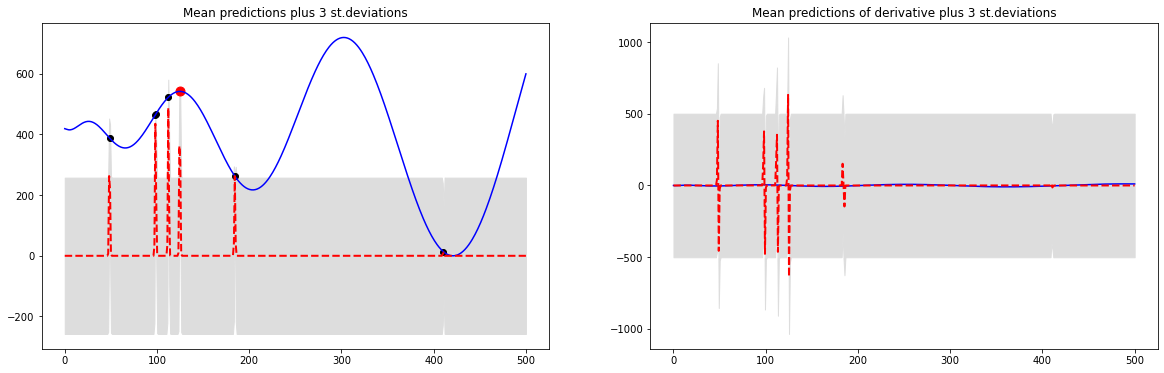

w:  [[147.9582397]]
lr:  0.1
df: [[0.]], s.d. [[37818.25689547]]
actual df [-5.20395279]


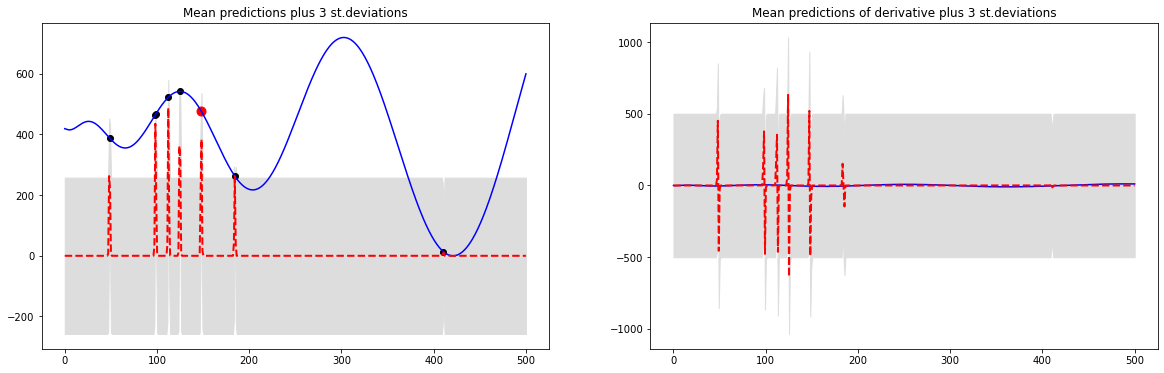

w:  [[117.9446511]]
lr:  0.1
df: [[-8.72985049e-22]], s.d. [[37818.25689547]]
actual df [1.72353363]


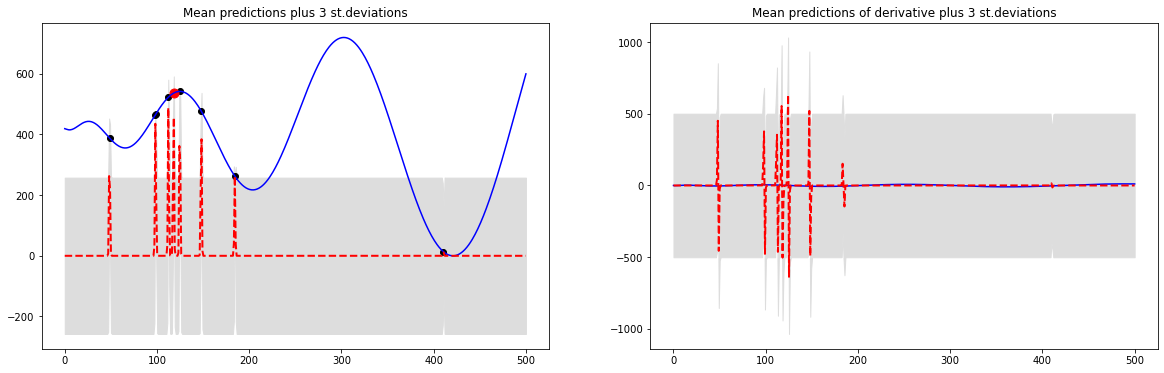

w:  [[113.31795392]]
lr:  0.1
df: [[-383.32228775]], s.d. [[32442.95973406]]
actual df [2.766716]
  # Optimal (ls, var) =  (1.0, 10000.0)


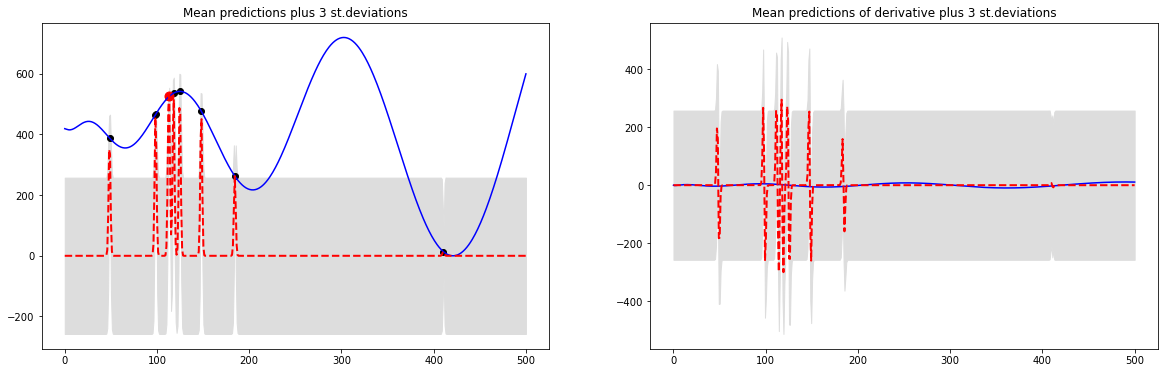

w:  [[127.42034526]]
lr:  0.1
df: [[-37.32554118]], s.d. [[9952.54931576]]
actual df [-0.66984558]


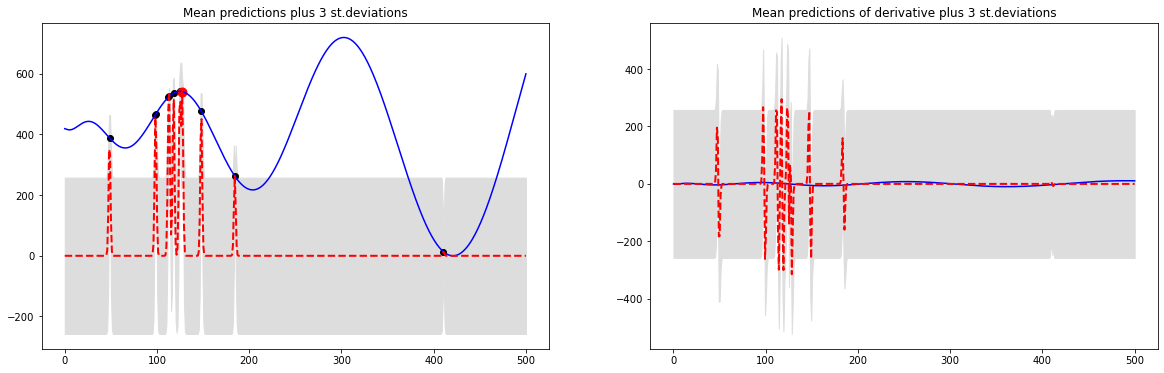

w:  [[122.00786189]]
lr:  0.1
df: [[36.49855485]], s.d. [[9950.76609234]]
actual df [0.72193146]


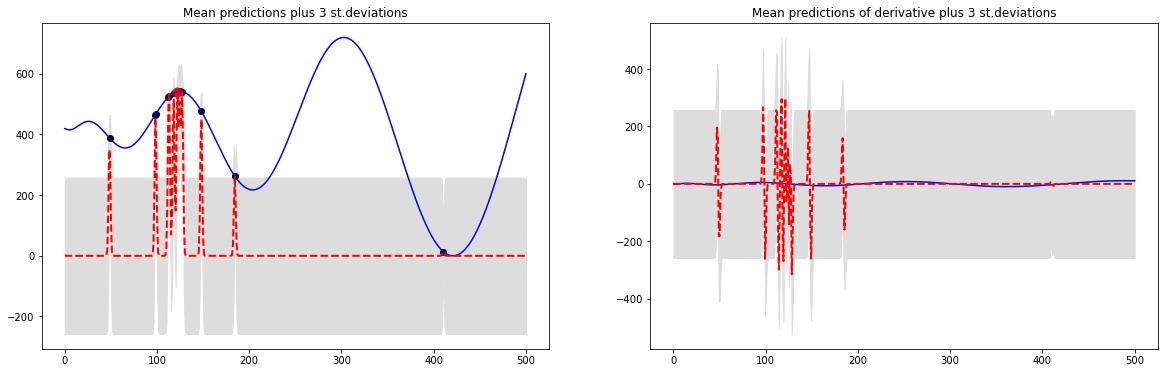

w:  [[143.95090591]]
lr:  0.1
df: [[0.62261601]], s.d. [[9999.98295897]]
actual df [-4.51736832]


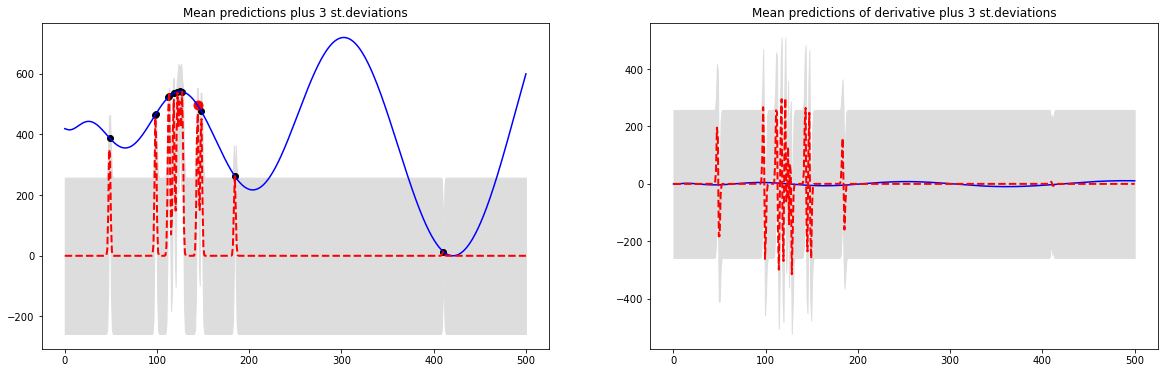

w:  [[122.31242293]]
lr:  0.1
df: [[-83.84211705]], s.d. [[8950.26138797]]
actual df [0.64472961]


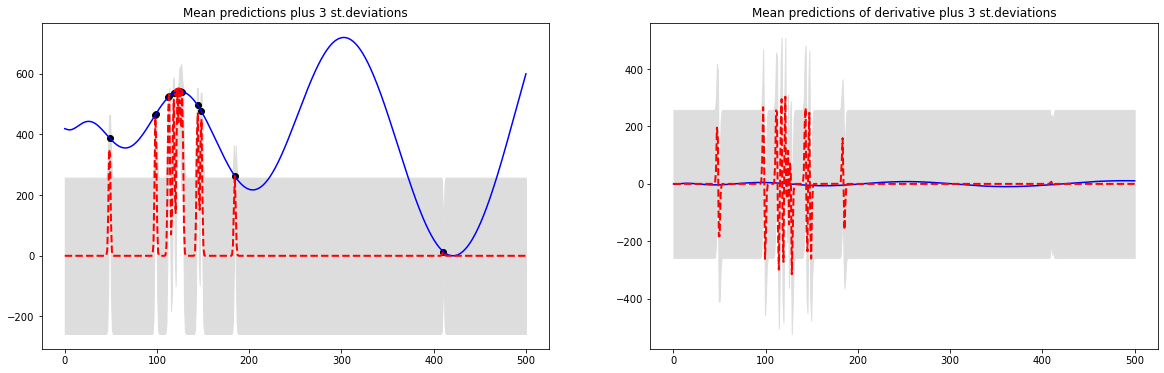

w:  [[129.00034789]]
lr:  0.1
df: [[-239.65855939]], s.d. [[7942.20353363]]
actual df [-1.07743835]
  # Optimal (ls, var) =  (1.0, 10000.0)


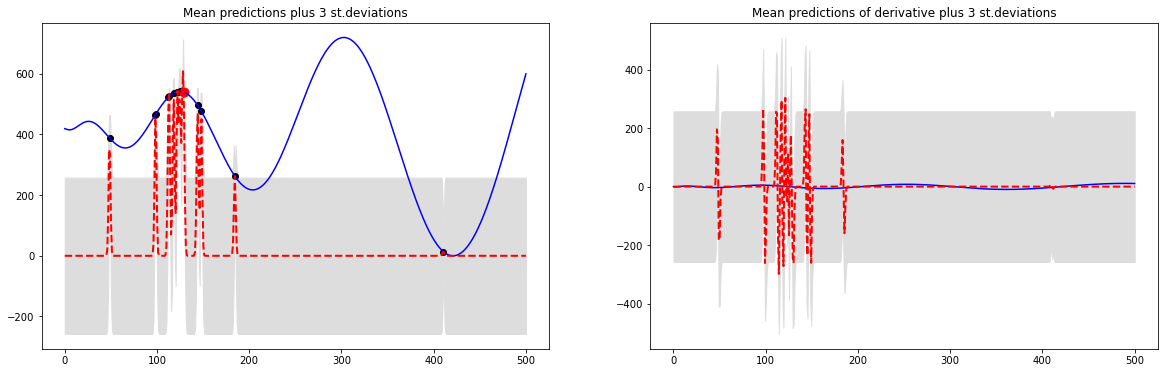

w:  [[147.67852334]]
lr:  0.1
df: [[126.47088244]], s.d. [[9276.33623527]]
actual df [-5.16034317]


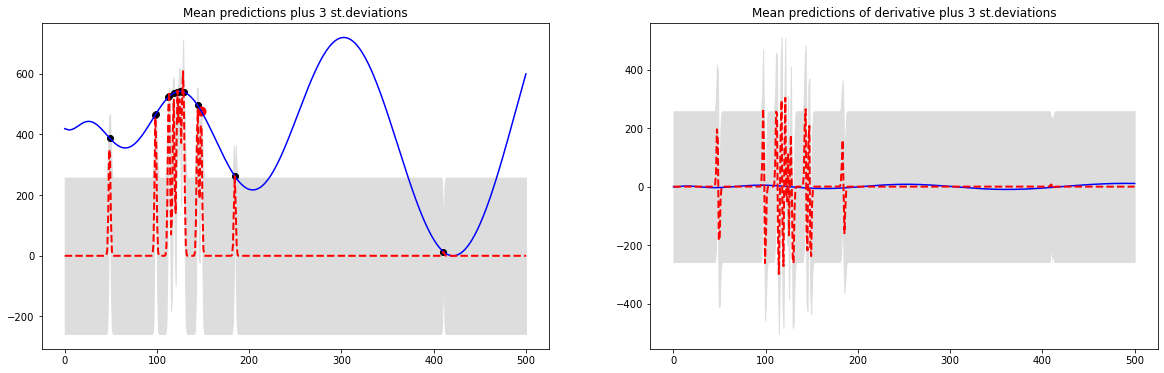

w:  [[139.70105725]]
lr:  0.1
df: [[0.25237292]], s.d. [[9999.9974126]]
actual df [-3.65744781]


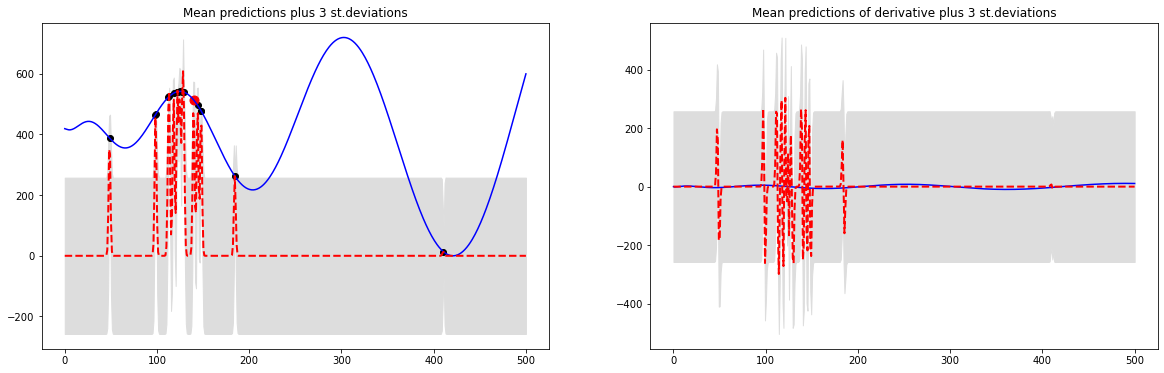

w:  [[133.55925014]]
lr:  0.1
df: [[-0.05914867]], s.d. [[9999.99978679]]
actual df [-2.22870636]


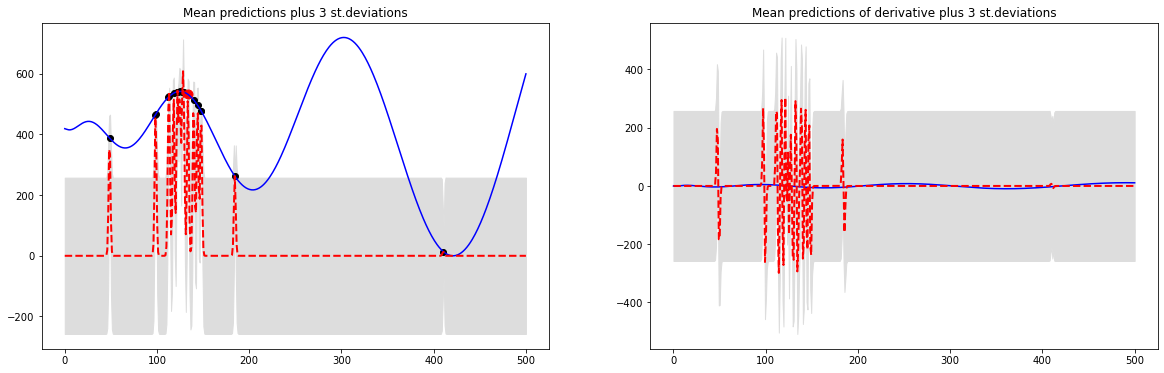

w:  [[142.30077299]]
lr:  0.1
df: [[164.28316013]], s.d. [[8132.97194438]]
actual df [-4.19831085]


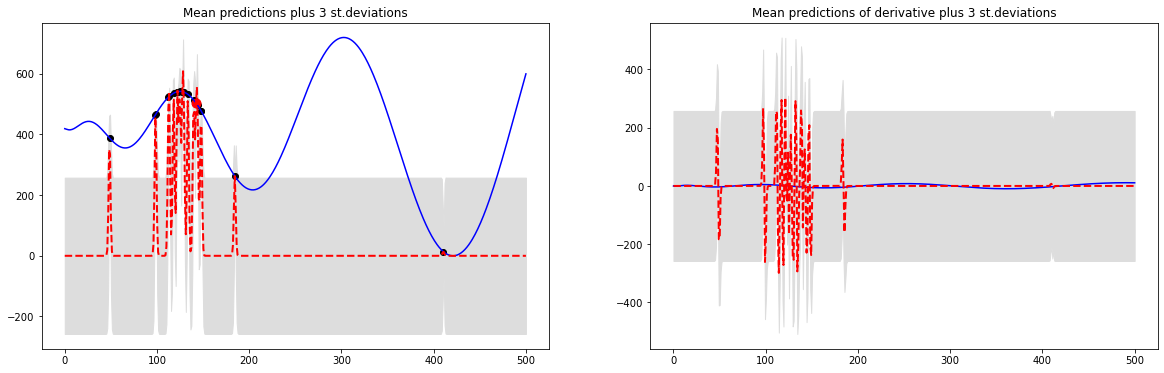

w:  [[112.77581683]]
lr:  0.1
df: [[44.34079098]], s.d. [[246.6306308]]
actual df [2.87982178]
  # Optimal (ls, var) =  (1.0, 10000.0)


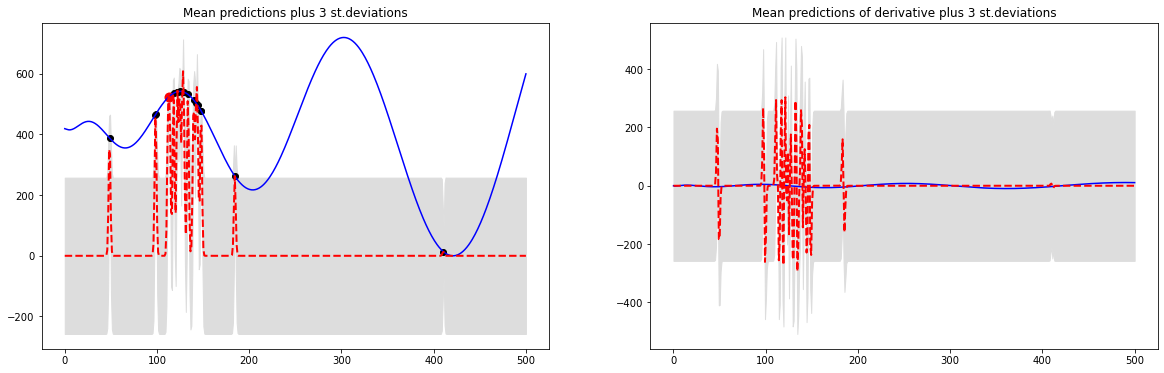

w:  [[111.7021967]]
lr:  0.1
df: [[186.66172753]], s.d. [[5237.98947519]]
actual df [3.09718323]


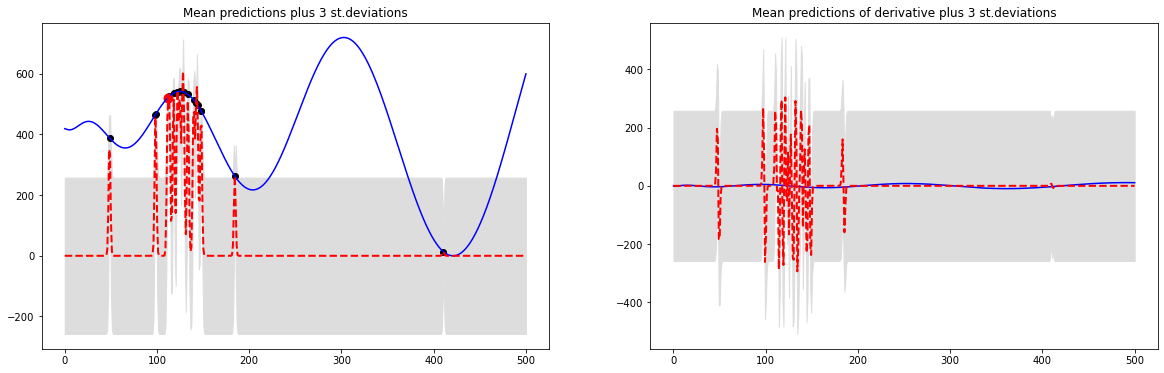

w:  [[106.7816917]]
lr:  0.1
df: [[0.01545406]], s.d. [[9999.99993789]]
actual df [3.96492767]


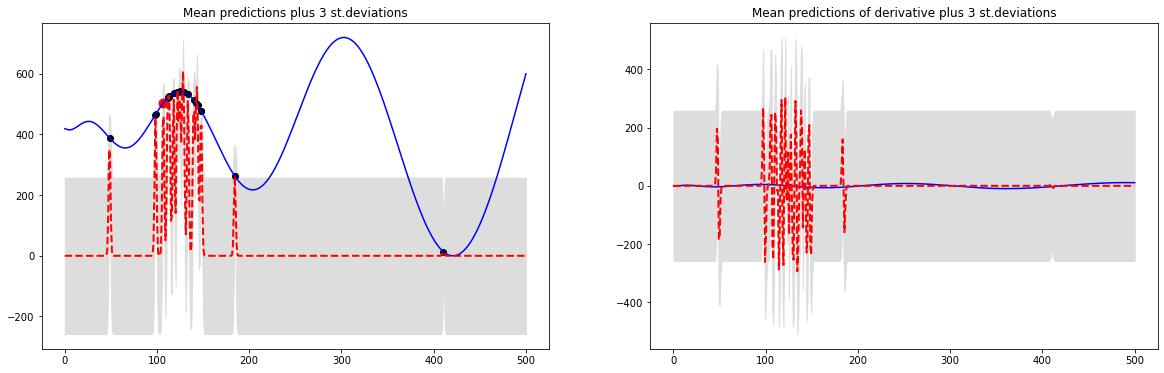

w:  [[108.32435567]]
lr:  0.1
df: [[-229.85897107]], s.d. [[7789.13127771]]
actual df [3.71744919]


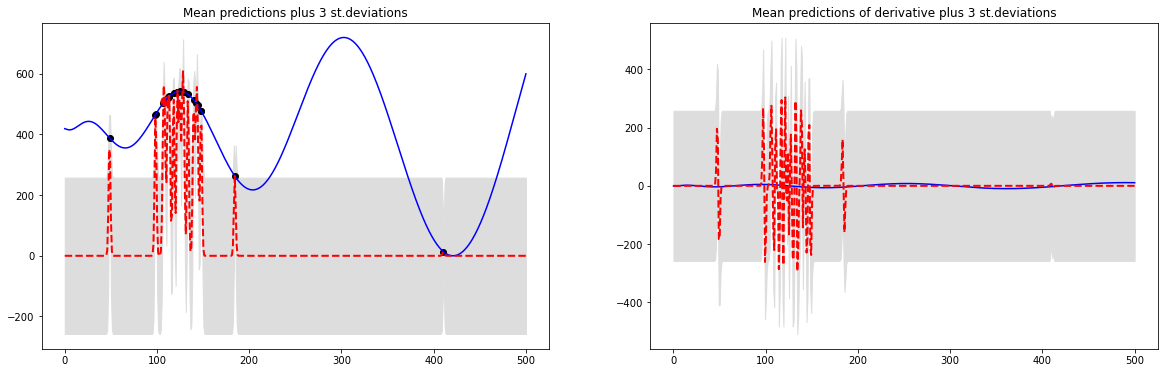

w:  [[118.24882724]]
lr:  0.1
df: [[-154.10334695]], s.d. [[9155.94067212]]
actual df [1.65080261]


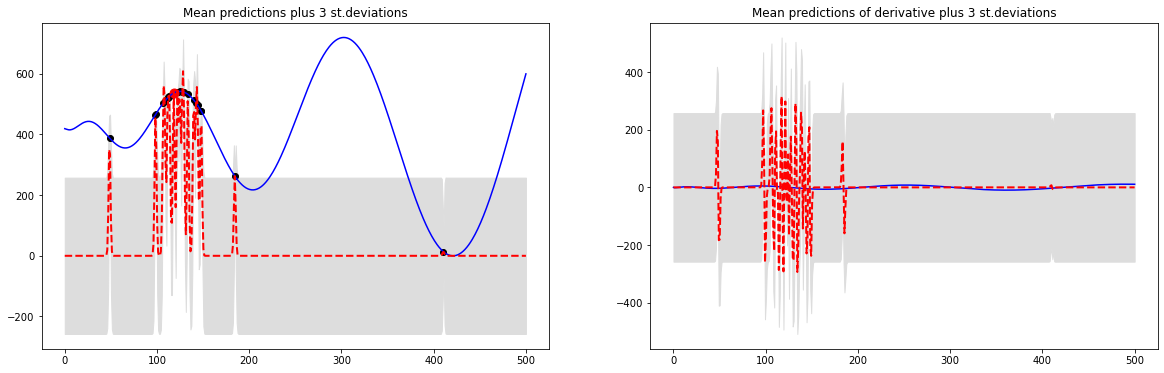

w:  [[125.67608293]]
lr:  0.1
df: [[-154.37148942]], s.d. [[4629.470702]]
actual df [-0.21867371]
  # Optimal (ls, var) =  (1.0, 10000.0)


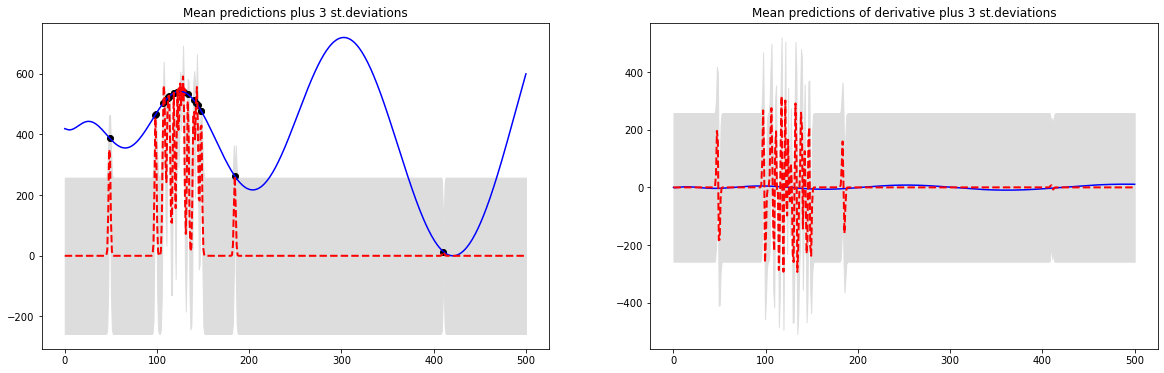

w:  [[135.48998145]]
lr:  0.1
df: [[-158.9980257]], s.d. [[9103.57142713]]
actual df [-2.69695282]


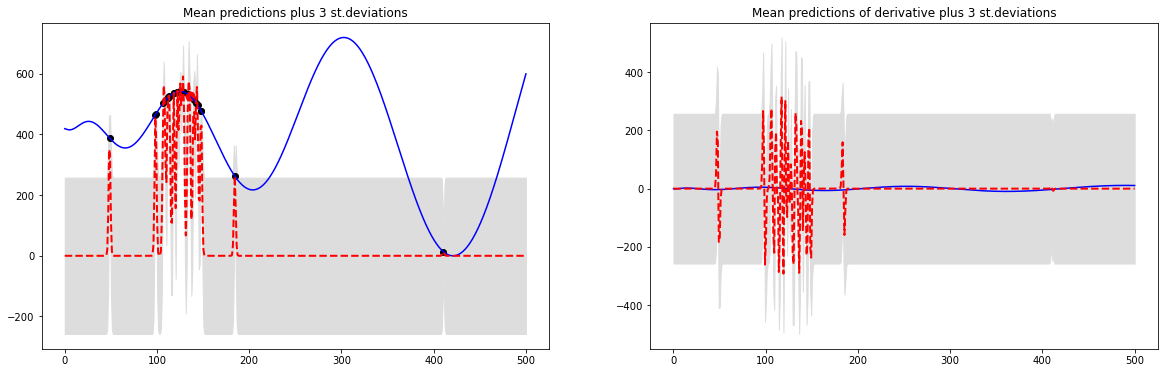

w:  [[147.87889097]]
lr:  0.1
df: [[-33.53927594]], s.d. [[74.22808514]]
actual df [-5.19164276]


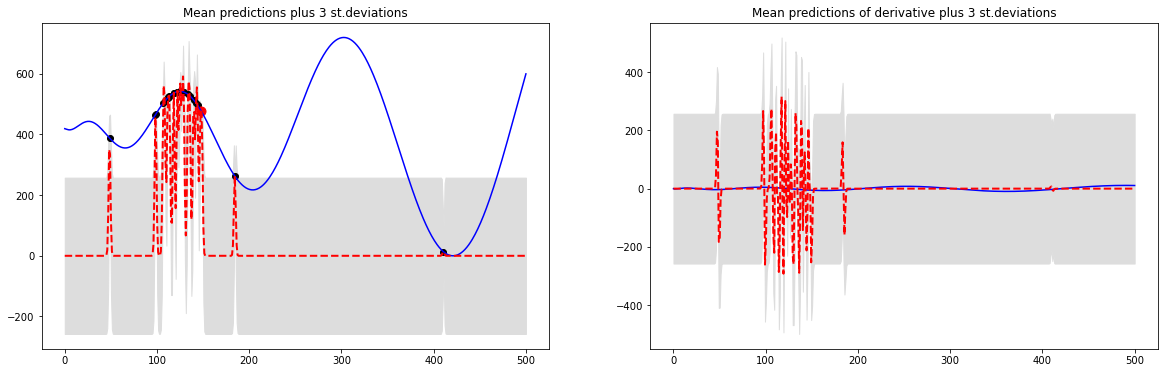

w:  [[148.40564184]]
lr:  0.1
df: [[-39.81306039]], s.d. [[1009.99390145]]
actual df [-5.2722702]


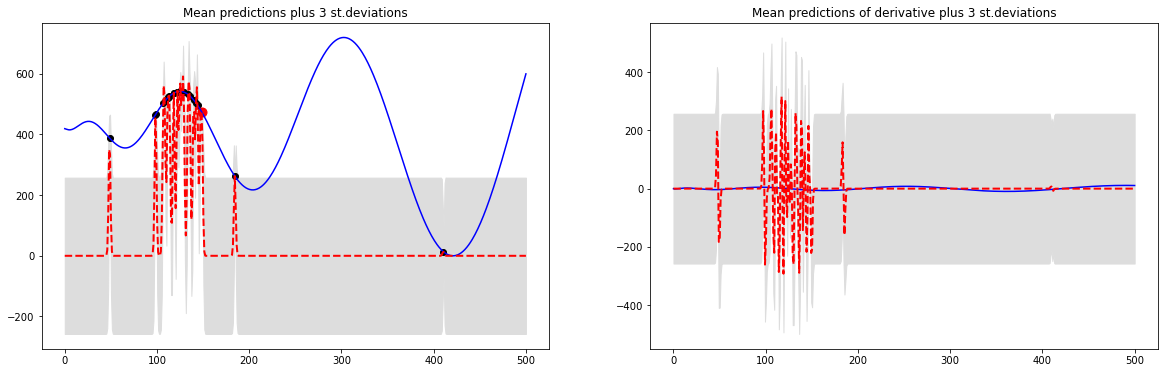

w:  [[150.21472267]]
lr:  0.1
df: [[-223.3654644]], s.d. [[5887.6178326]]
actual df [-5.53050232]


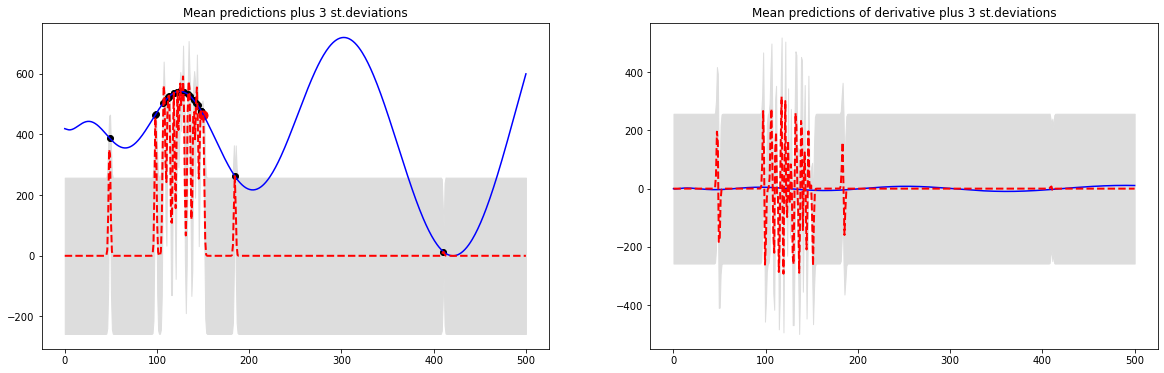

w:  [[157.41205746]]
lr:  0.1
df: [[-1.82492739e-08]], s.d. [[10000.]]
actual df [-6.25198364]
  # Optimal (ls, var) =  (1.0, 10000.0)


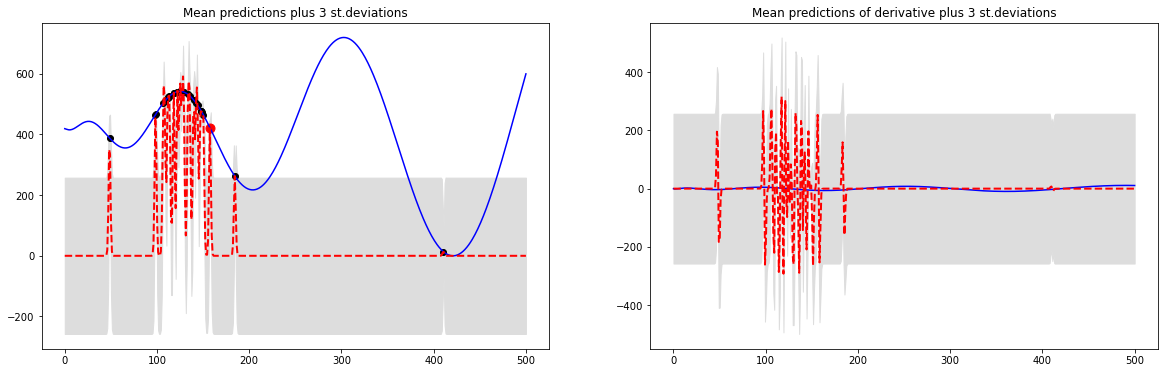

w:  [[156.45611201]]
lr:  0.1
df: [[255.52893288]], s.d. [[6335.6735761]]
actual df [-6.18545532]


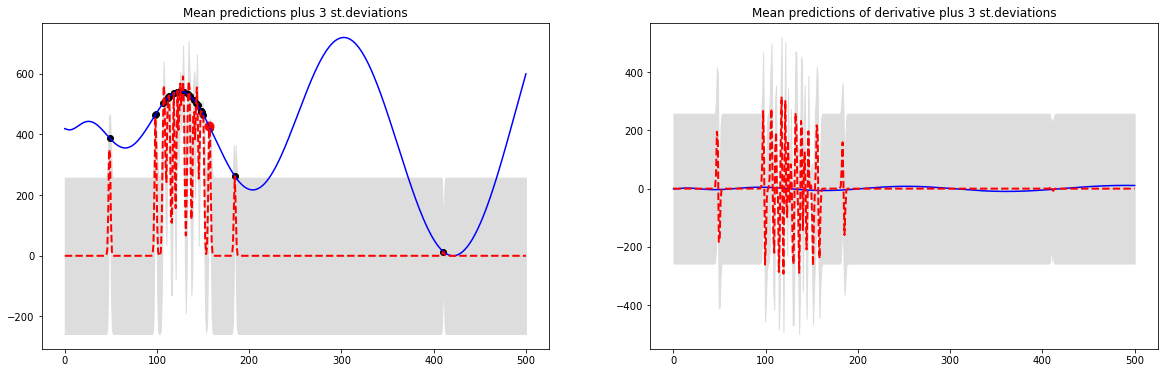

w:  [[139.15932402]]
lr:  0.1
df: [[240.93669523]], s.d. [[7810.97370256]]
actual df [-3.5393219]


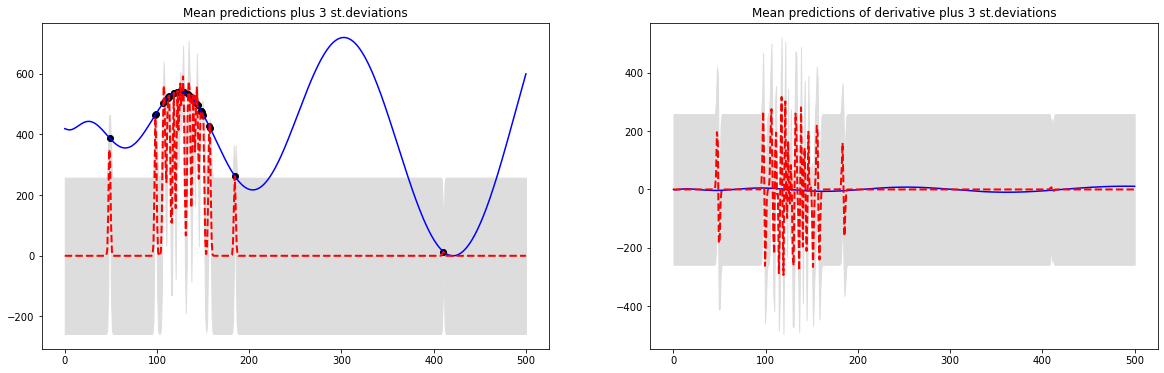

w:  [[137.3415914]]
lr:  0.1
df: [[-9.93261979]], s.d. [[6696.92163737]]
actual df [-3.13072205]


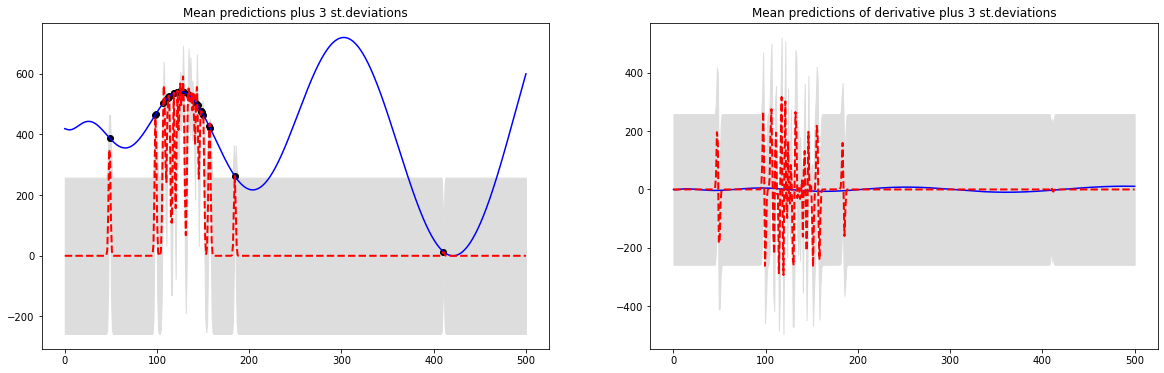

w:  [[140.71871049]]
lr:  0.1
df: [[-104.36185205]], s.d. [[3756.94007609]]
actual df [-3.87443161]


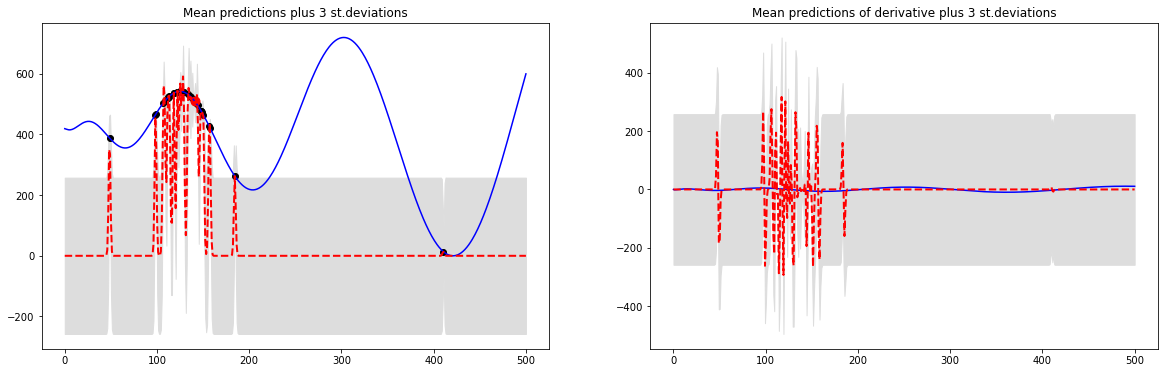

w:  [[137.2408074]]
lr:  0.1
df: [[5.92636545]], s.d. [[6491.48898647]]
actual df [-3.10753632]
  # Optimal (ls, var) =  (1.0, 10000.0)


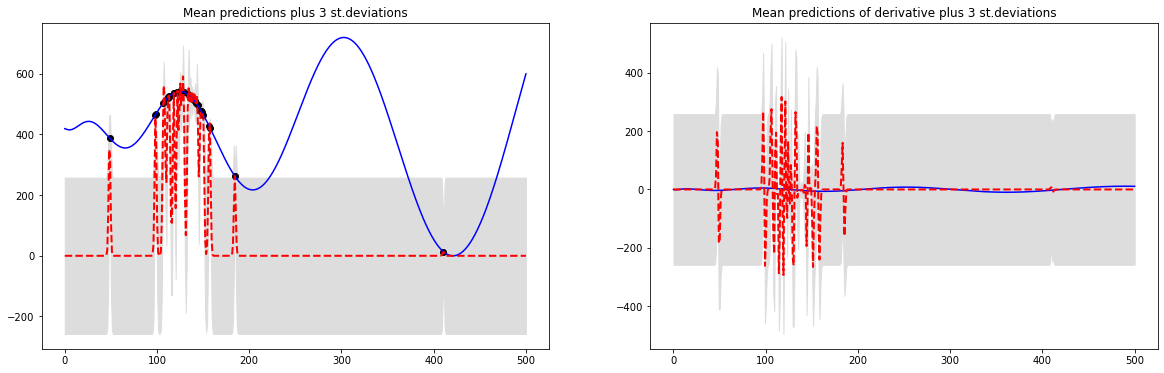

w:  [[137.30109473]]
lr:  0.1
df: [[-3.46000931]], s.d. [[0.85409053]]
actual df [-3.12141418]


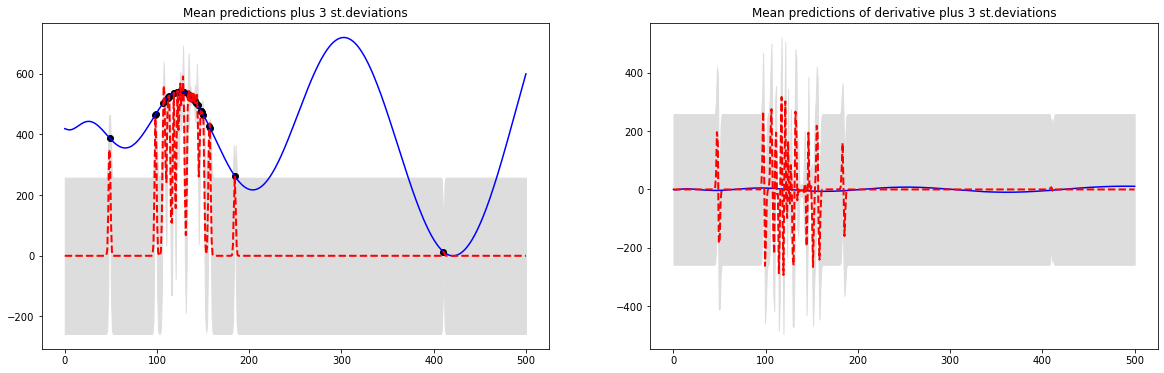

w:  [[137.60320857]]
lr:  0.1
df: [[-3.9483233]], s.d. [[24.12237502]]
actual df [-3.19064331]


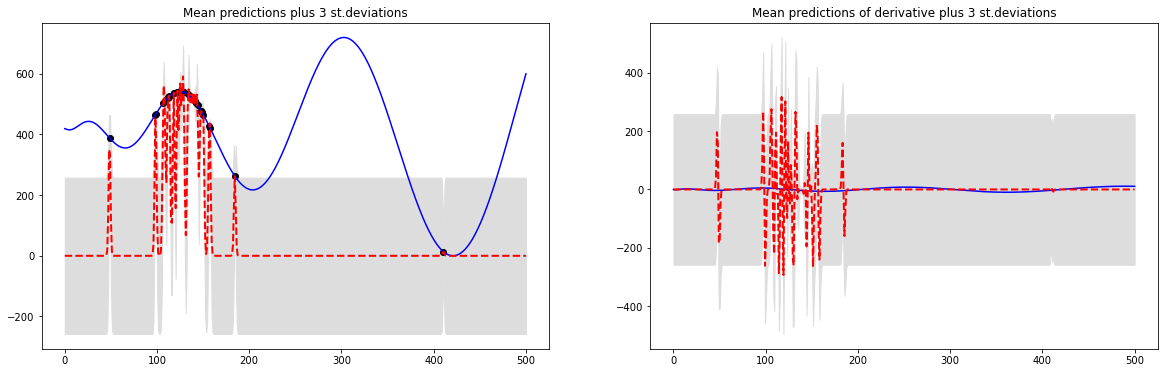

w:  [[137.95614503]]
lr:  0.1
df: [[-2.61367802]], s.d. [[10.91380156]]
actual df [-3.27089691]


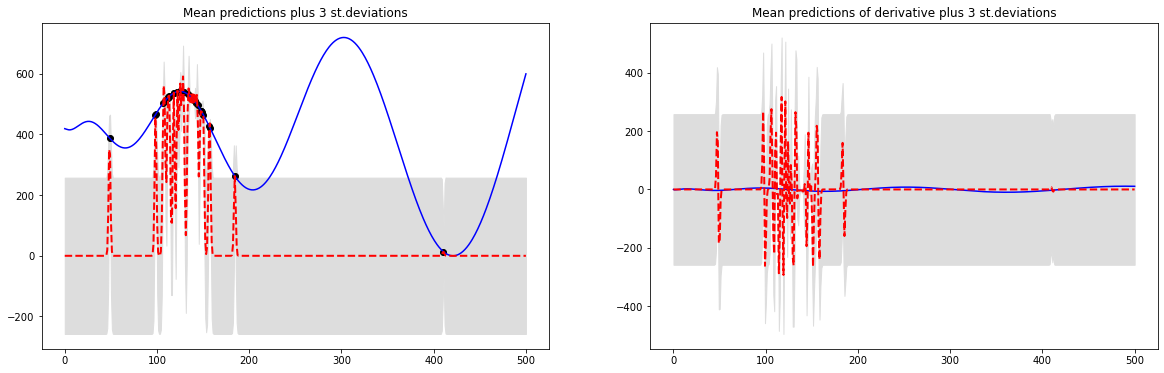

w:  [[138.27433634]]
lr:  0.1
df: [[-3.27837671]], s.d. [[2.3369782]]
actual df [-3.34267426]


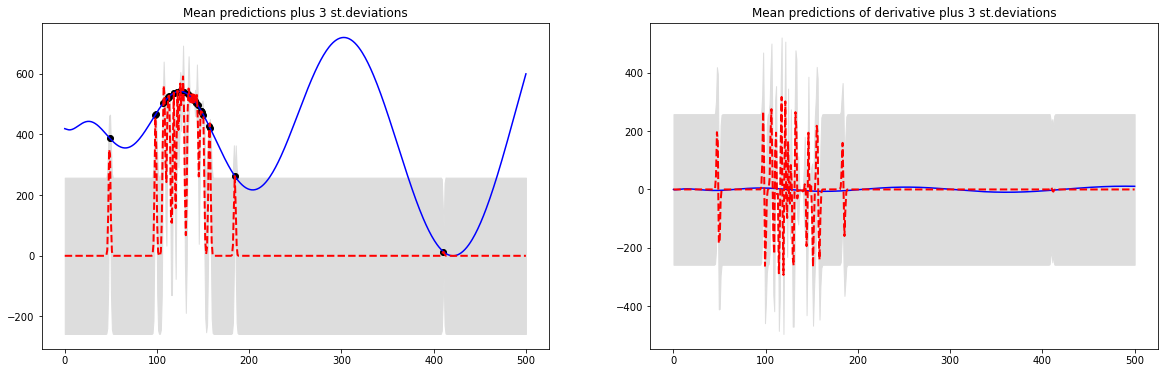

w:  [[138.60952063]]
lr:  0.1
df: [[-3.36788481]], s.d. [[0.30382085]]
actual df [-3.41768646]
  # Optimal (ls, var) =  (1.0, 8920.684895066099)


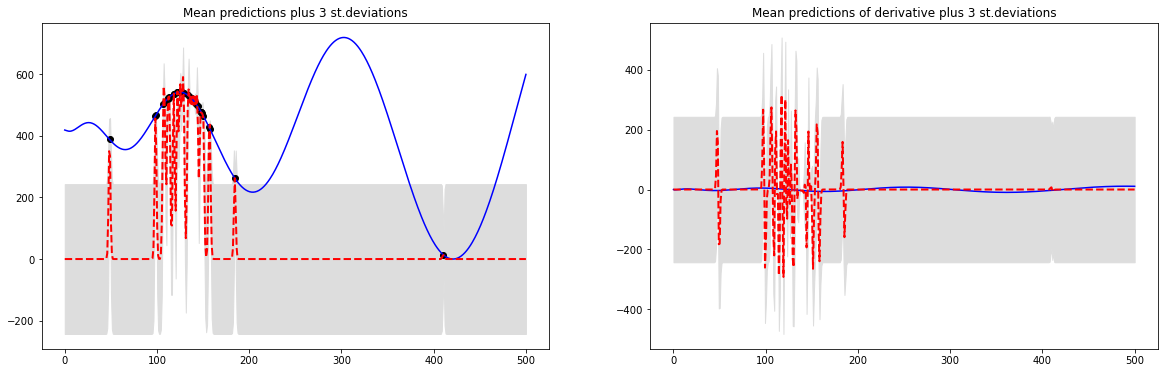

w:  [[138.9452515]]
lr:  0.1
df: [[-3.4889684]], s.d. [[0.0002865]]
actual df [-3.49216461]


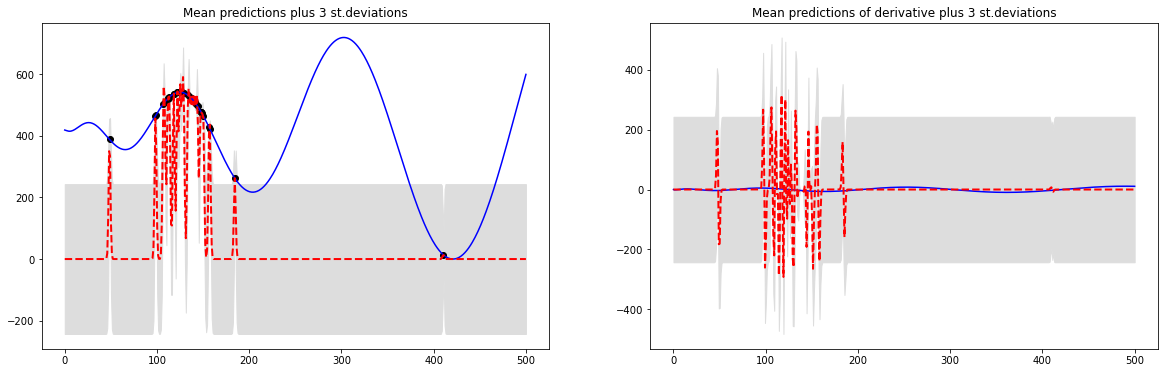

w:  [[139.29391443]]
lr:  0.1
df: [[-3.56991726]], s.d. [[0.00395046]]
actual df [-3.56884003]


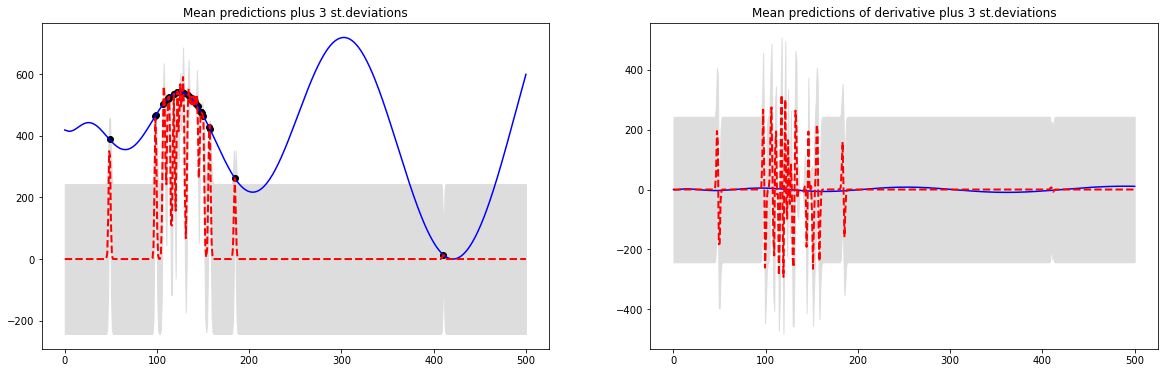

w:  [[139.65090973]]
lr:  0.1
df: [[-3.64443251]], s.d. [[0.00350835]]
actual df [-3.64659119]


In [21]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(gp.X, gp.y, 'ko', markersize=6)
    ax1.plot(w, f(w), 'ro', markersize=9)
    
    ax1.plot(Grid.flat, clean_f(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

    ax1.plot(Grid, mu, 'r--', lw=2)
    fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')

    filename = 'Ackley_' + str(i) + '_demo' +'.png' # name for different 
    pl.savefig('1D_Plots/' + filename)
    pl.show()  

    # 1. gradient descent
    lr = 0.1
    w = np.clip(w - lr * grad_sample(gp, w), lb, ub)

    #     2. nesterov
#     lr = 0.01
#     v = 0.9*v + lr*grad(gp, w-0.9*v)
#     w = np.clip(w - v, lb, ub)
    
    # 3. Adam
    # approximate first and second moment
#     gt = grad(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * lr * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w
    
    print('w: ', w)
    print('lr: ', lr)
    m, v = gp.posterior_grad(w)
    print('df:', m, end=', ')
    print('s.d.', v)
    print('actual df', optimize.approx_fprime(w[0], lambda x: clean_f(x).item(), eps))
#     print('desc:', -gt)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    if i % 5 == 1:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

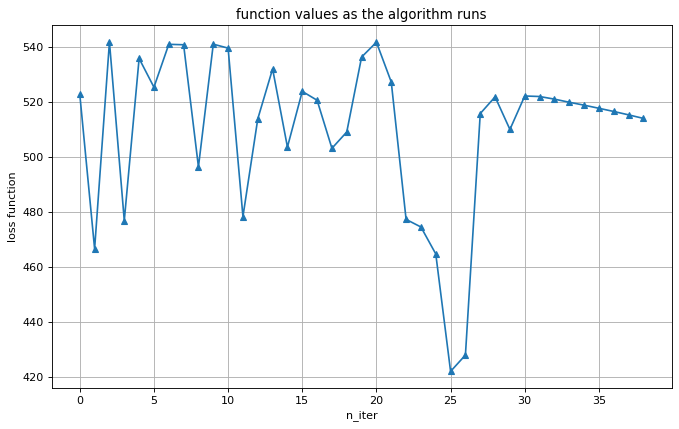

In [22]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [21]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

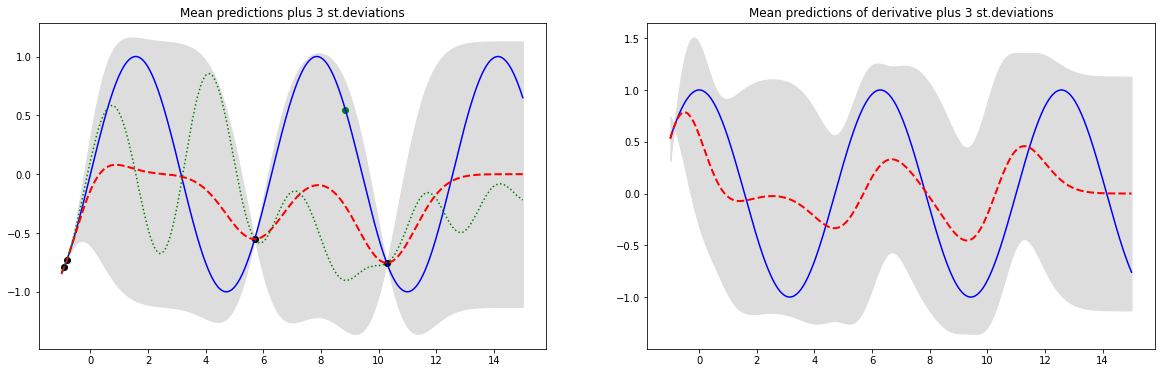

w:  [8.84368737]


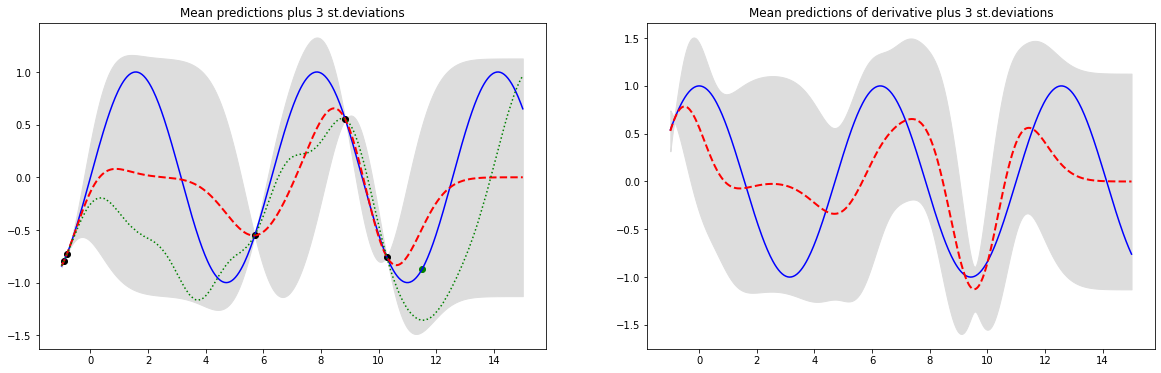

w:  [11.50501002]


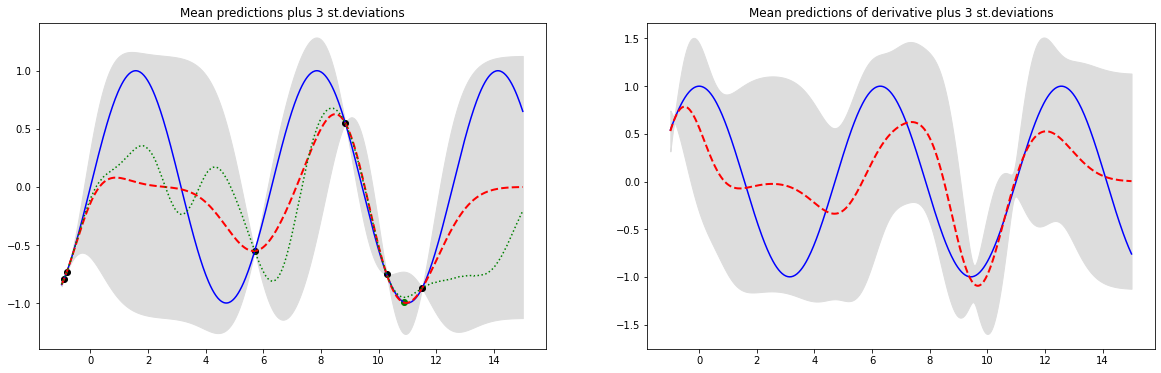

w:  [10.89579158]


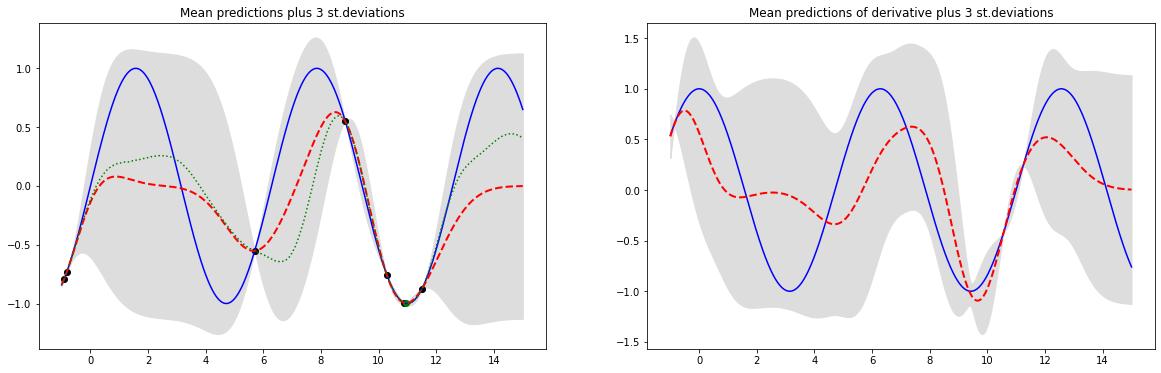

w:  [10.95991984]


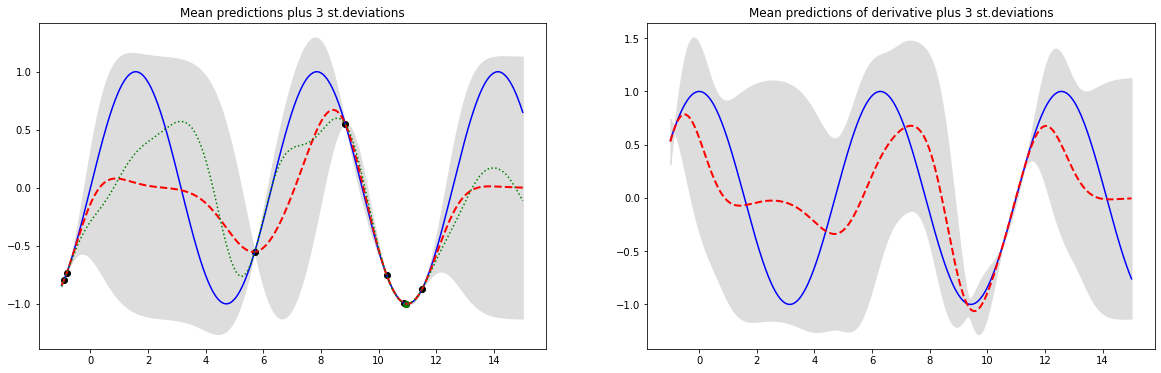

w:  [10.95991984]


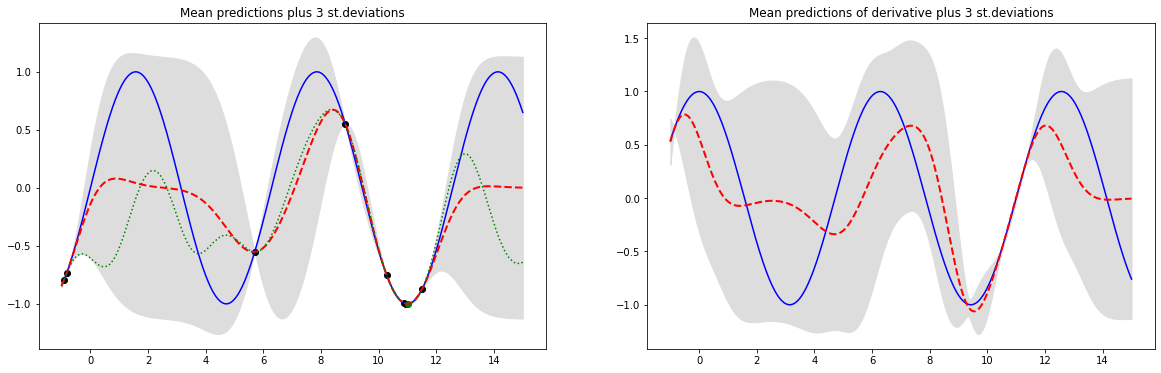

w:  [11.0240481]


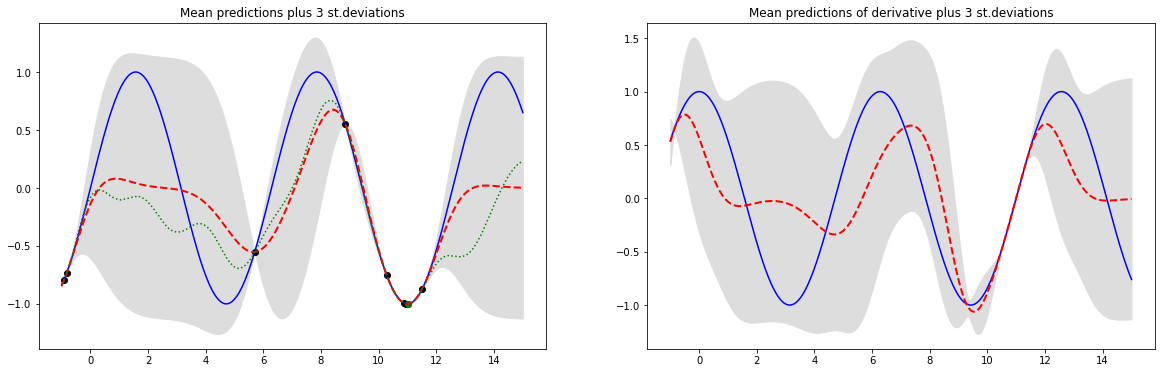

w:  [11.0240481]


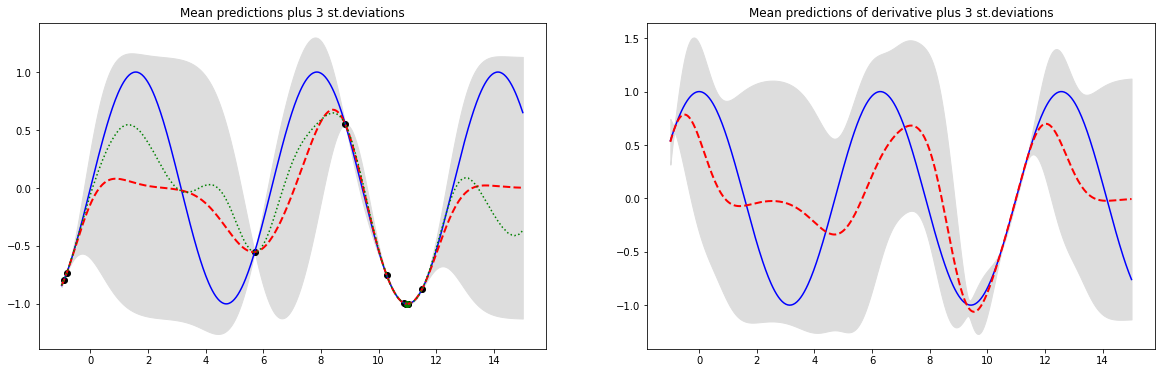

w:  [10.99198397]


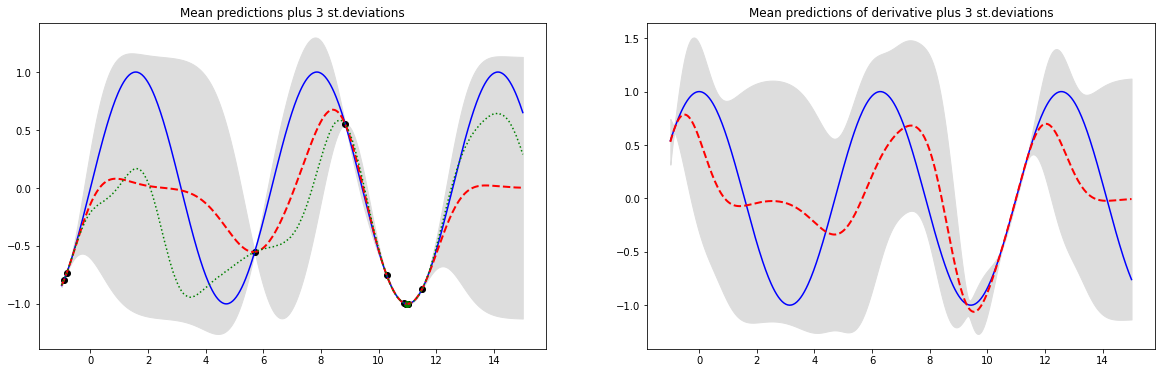

w:  [10.99198397]


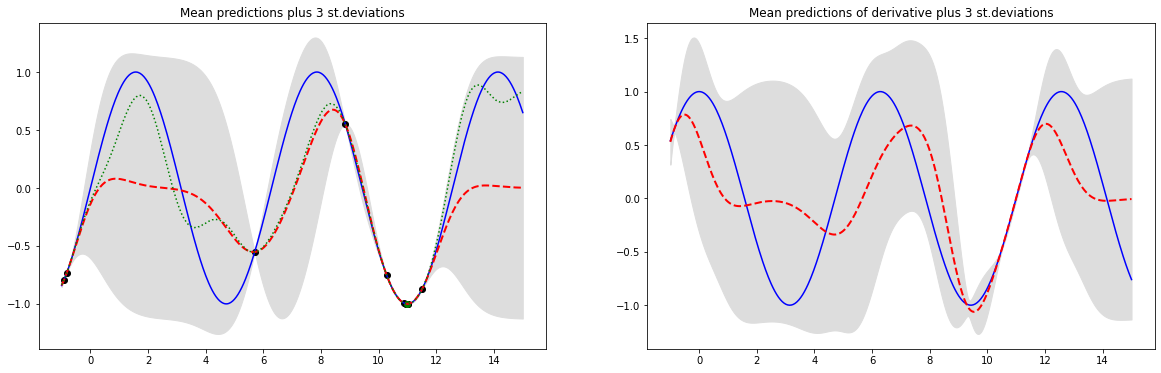

w:  [10.99198397]


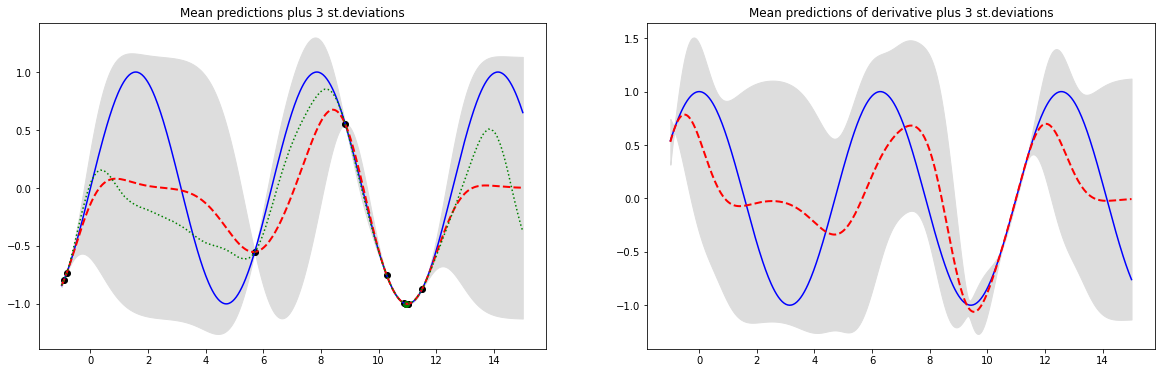

w:  [10.95991984]


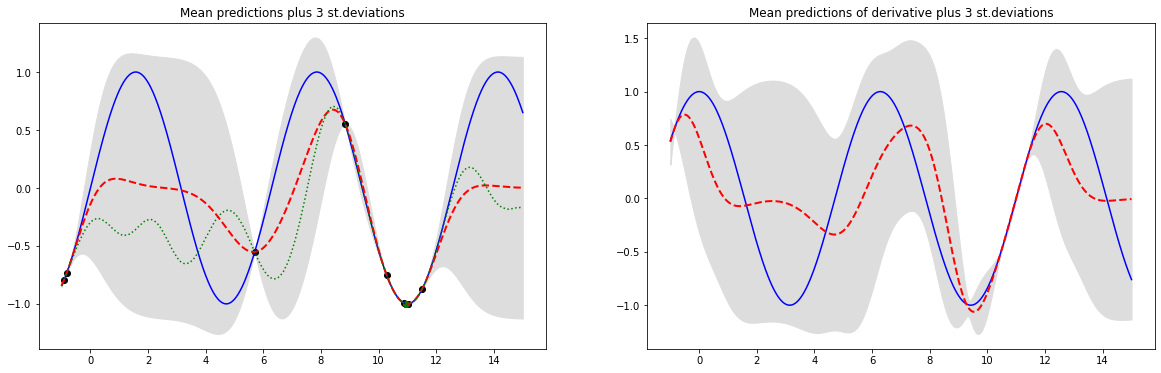

w:  [10.95991984]


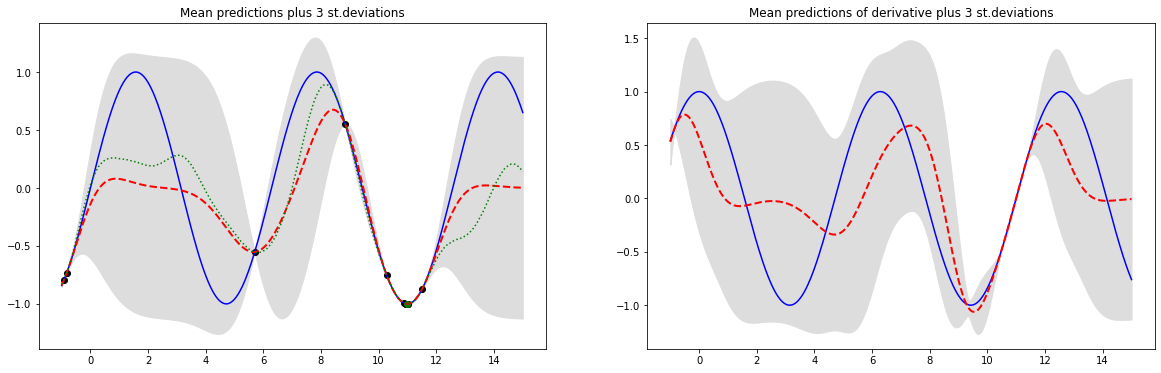

w:  [10.99198397]


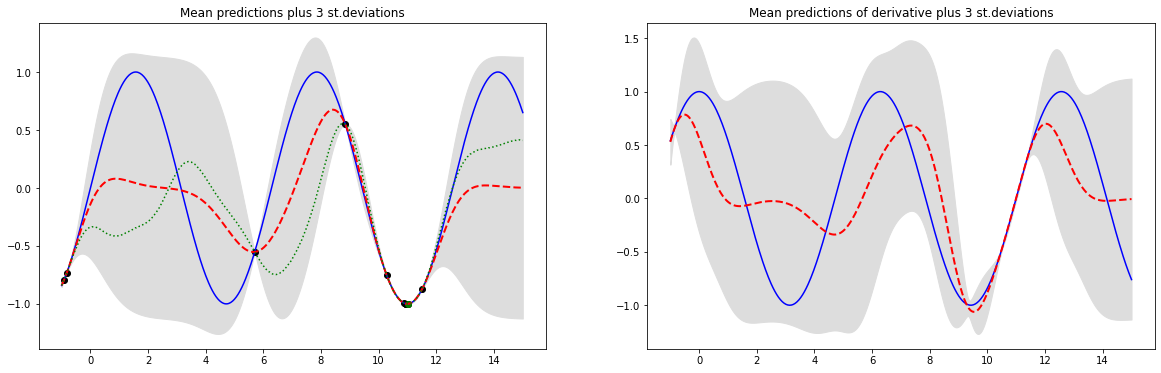

w:  [11.0240481]


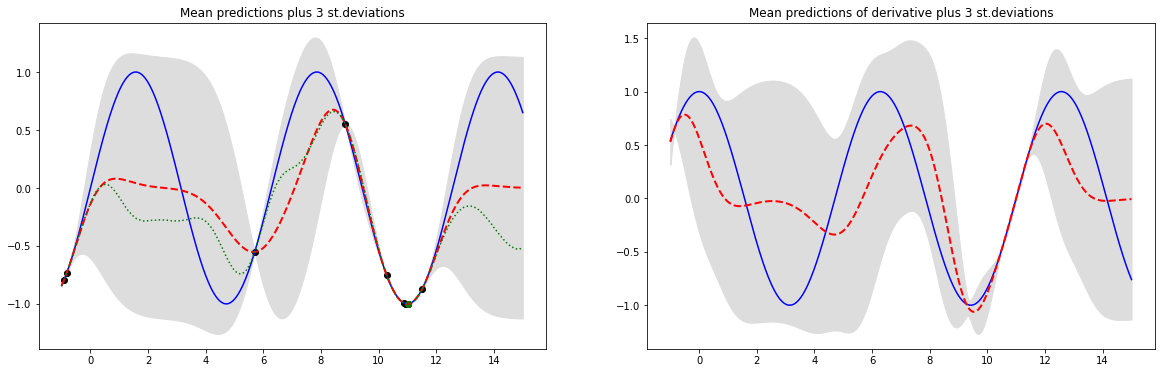

w:  [11.0240481]


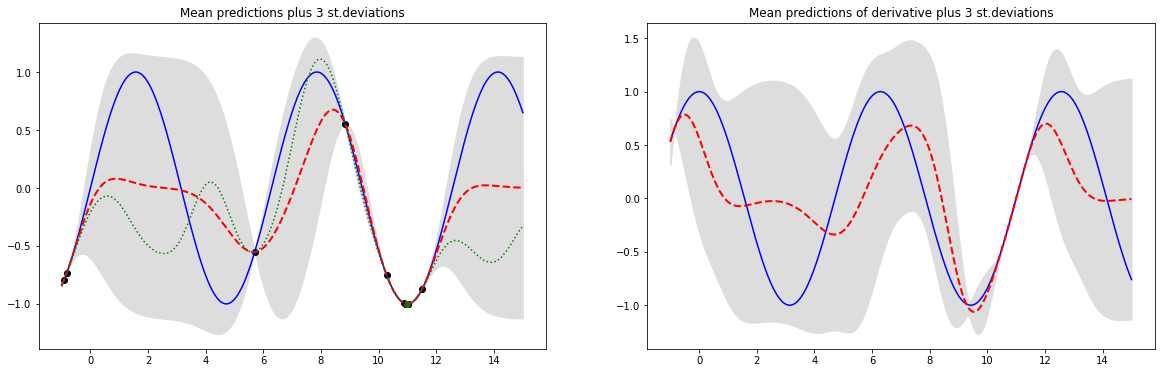

w:  [10.99198397]


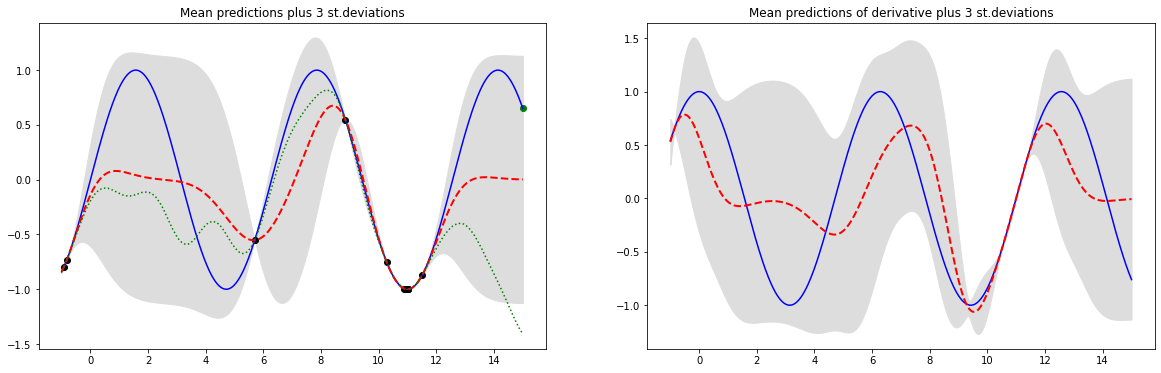

w:  [15.]


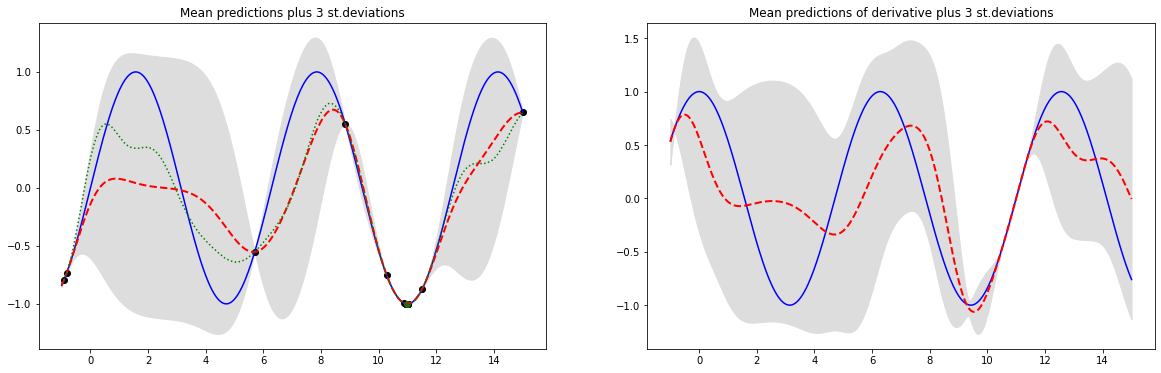

w:  [10.99198397]


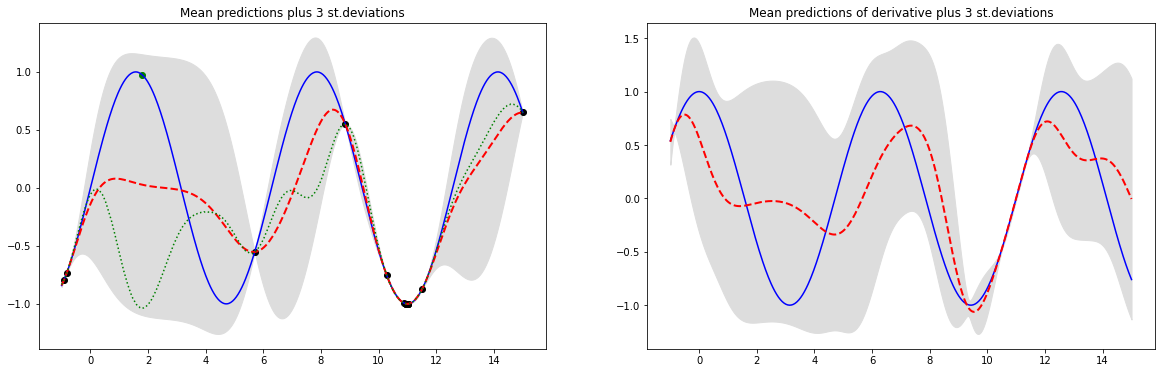

w:  [1.78957916]


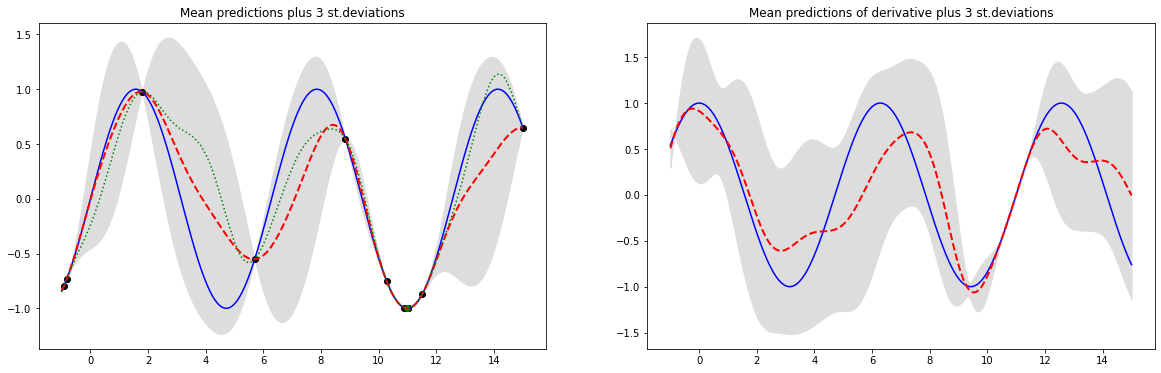

w:  [10.99198397]


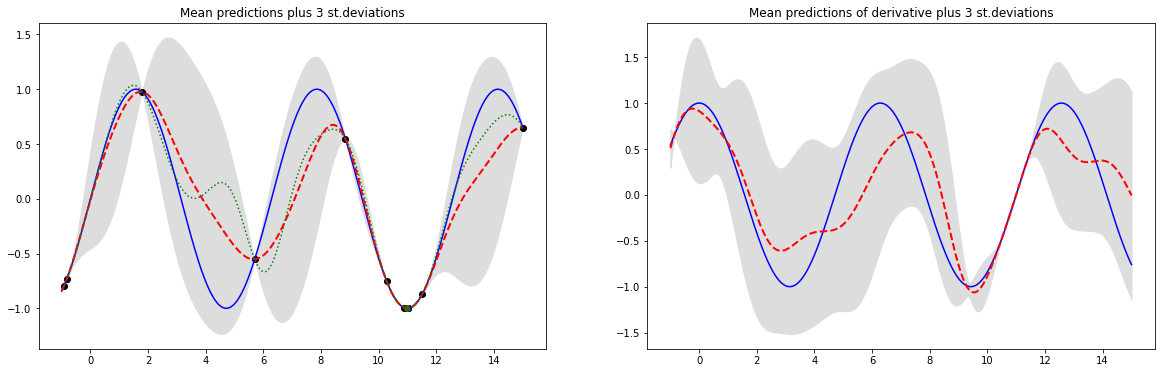

w:  [10.99198397]


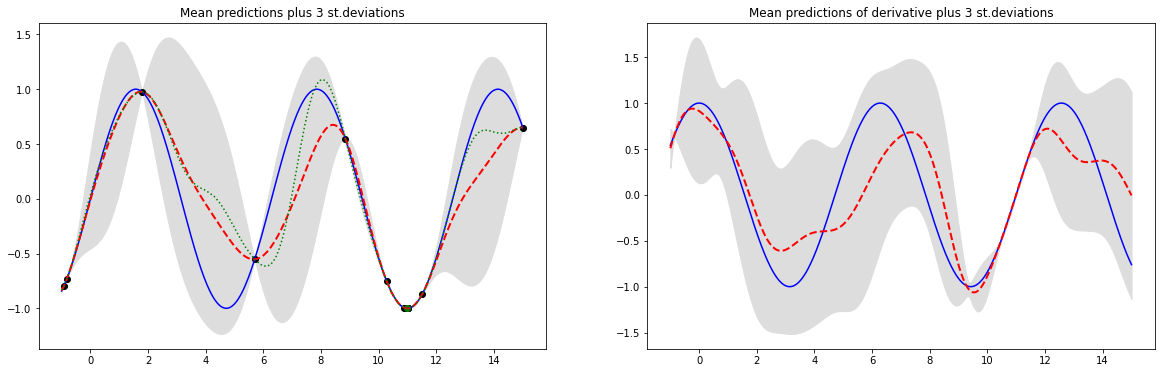

w:  [10.99198397]


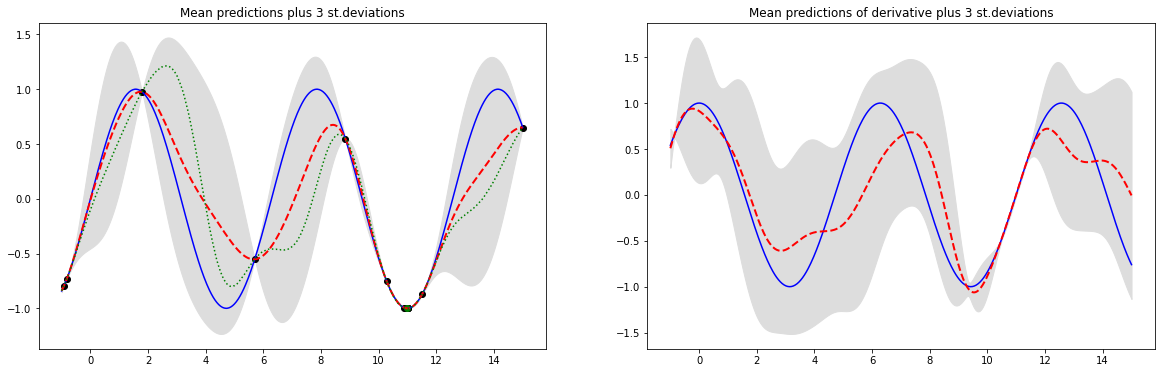

w:  [10.99198397]


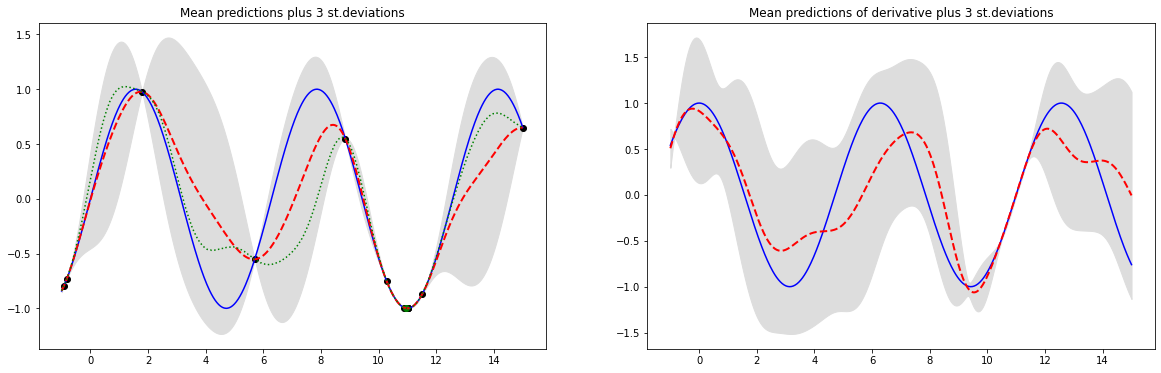

w:  [10.95991984]


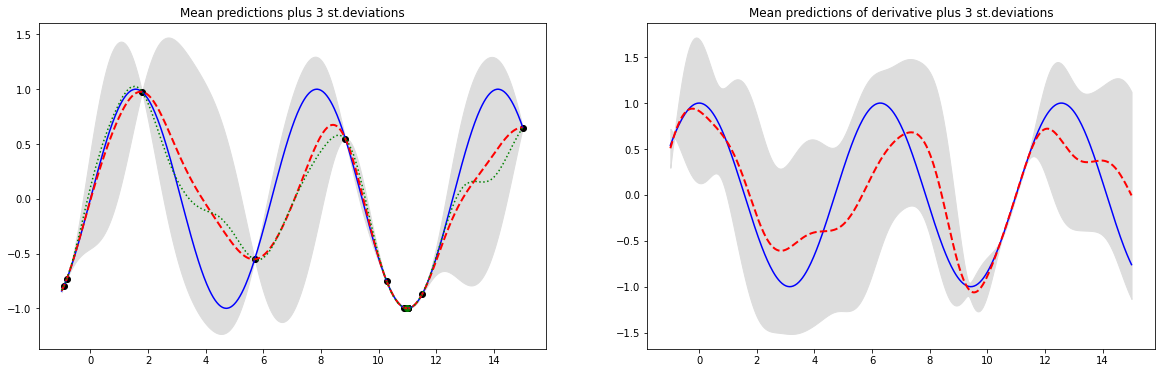

w:  [10.99198397]


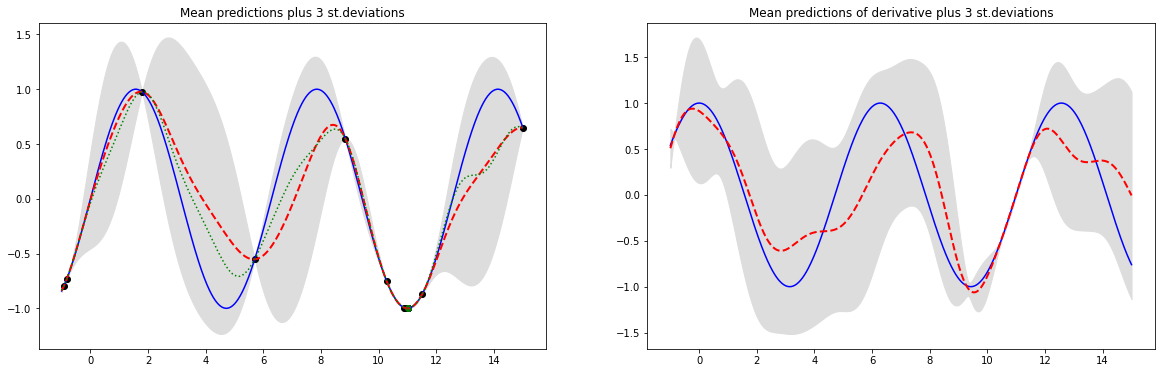

w:  [11.0240481]


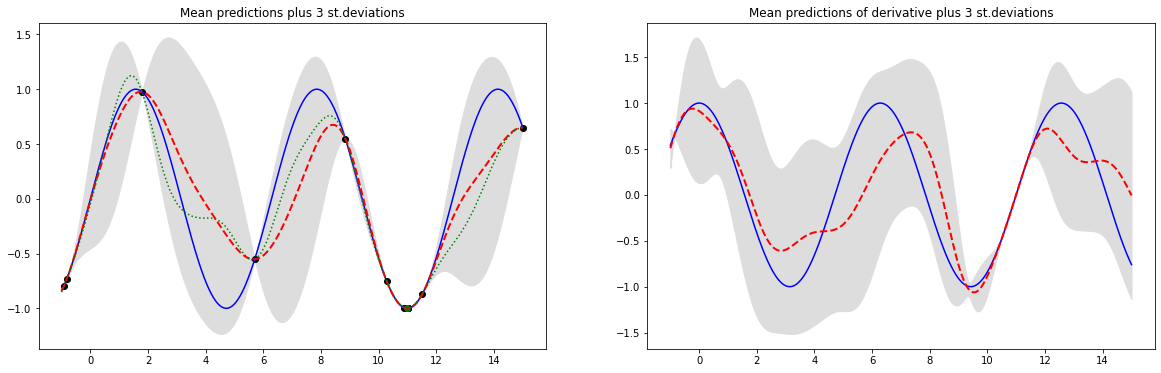

w:  [10.99198397]


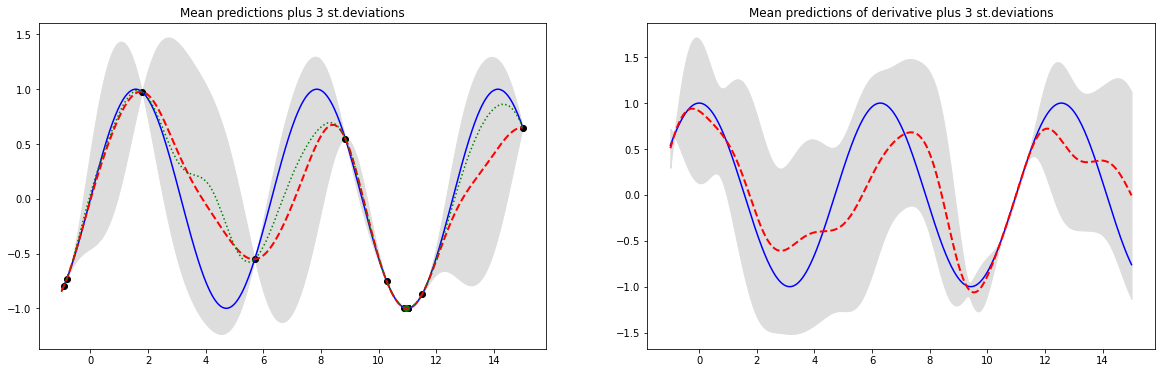

w:  [10.95991984]


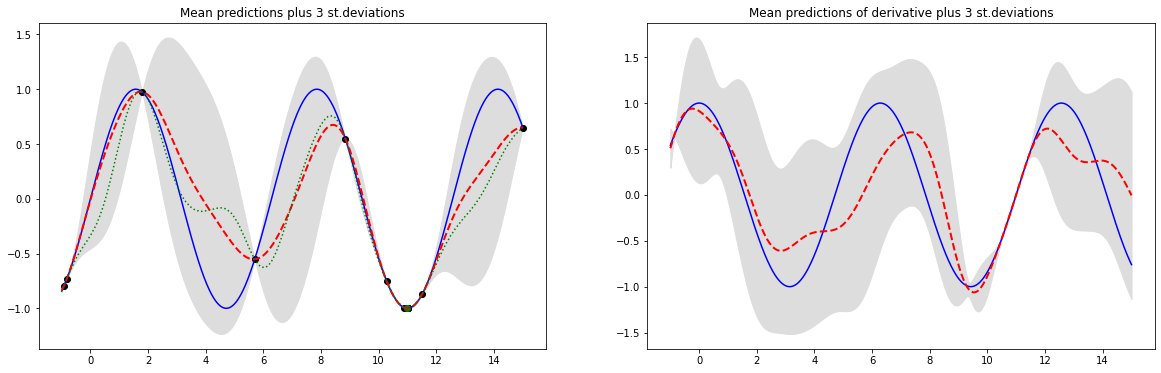

w:  [10.99198397]


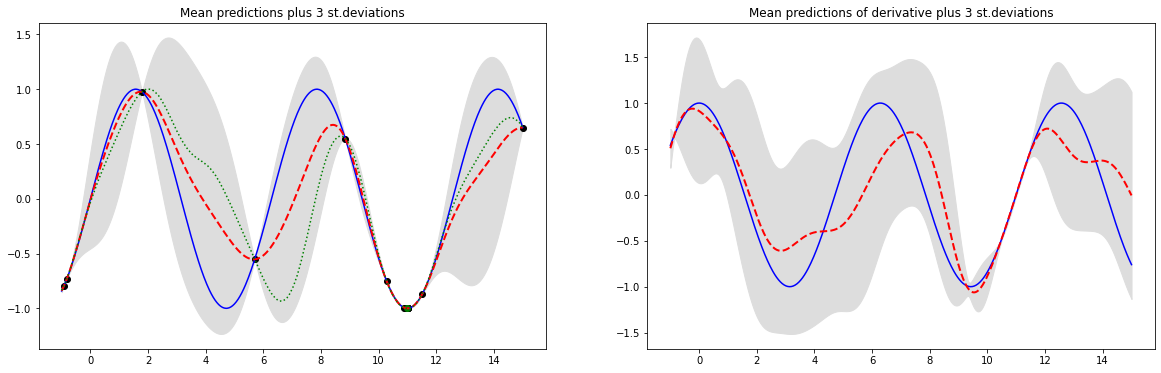

w:  [10.99198397]


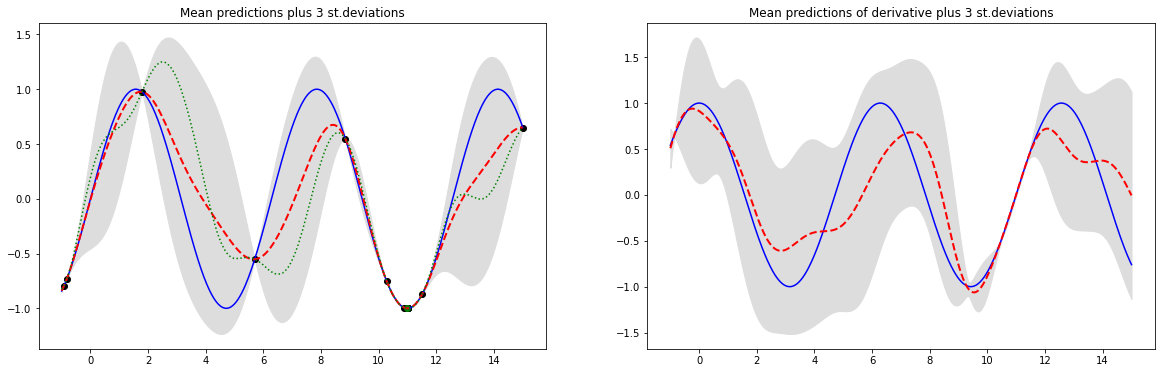

w:  [10.99198397]


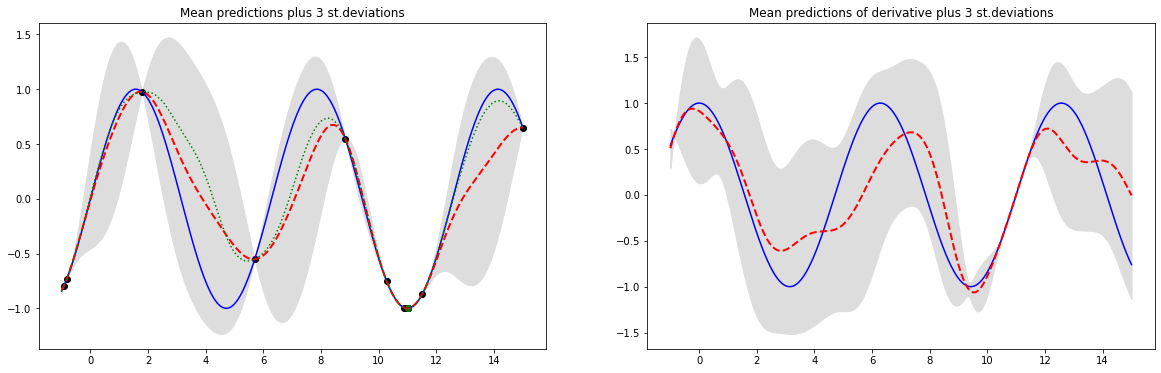

w:  [11.0240481]


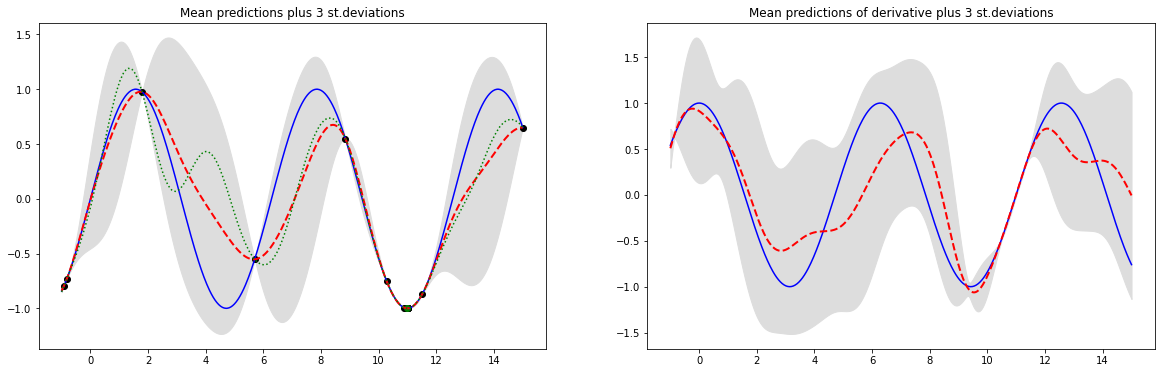

w:  [10.99198397]


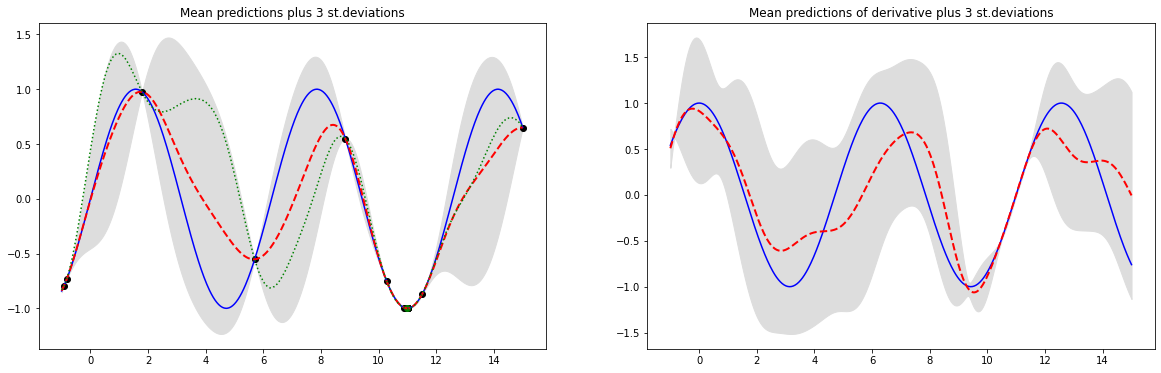

w:  [10.99198397]


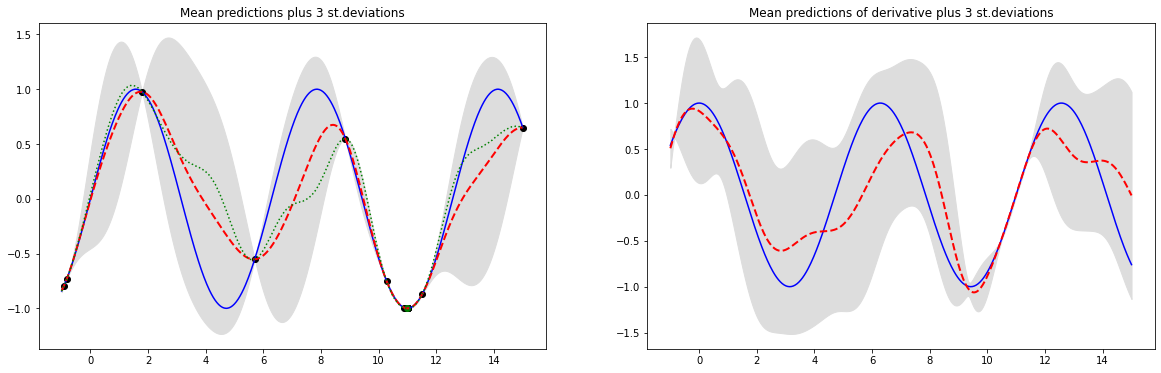

w:  [10.99198397]


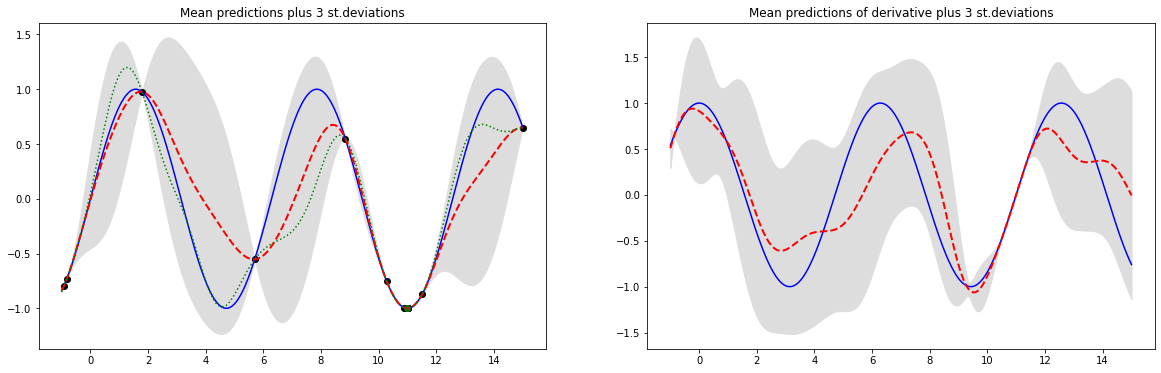

w:  [10.99198397]


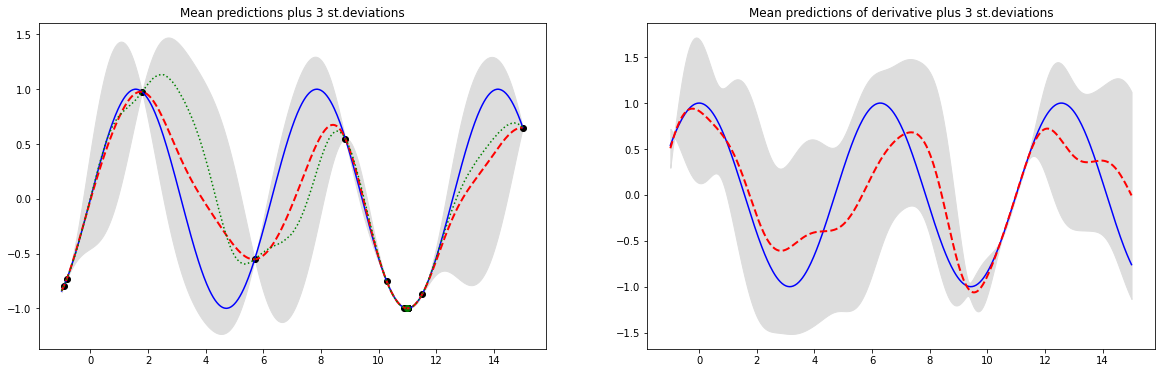

w:  [10.99198397]


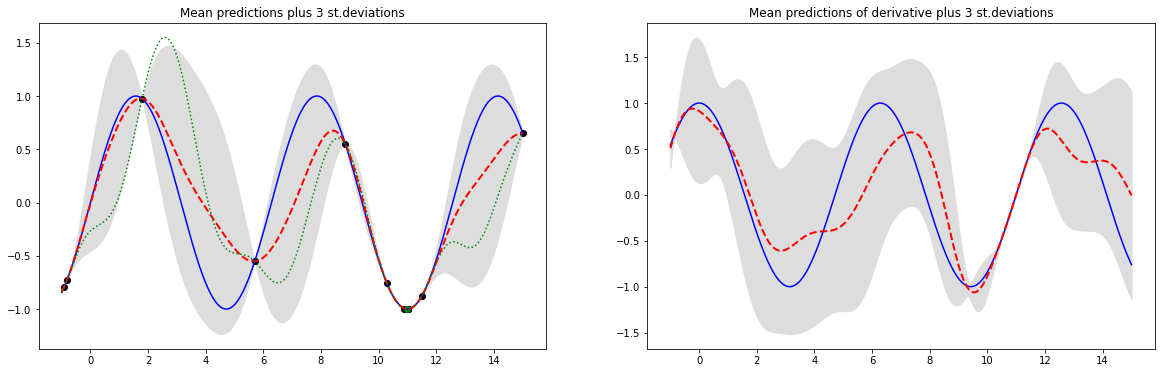

w:  [10.99198397]


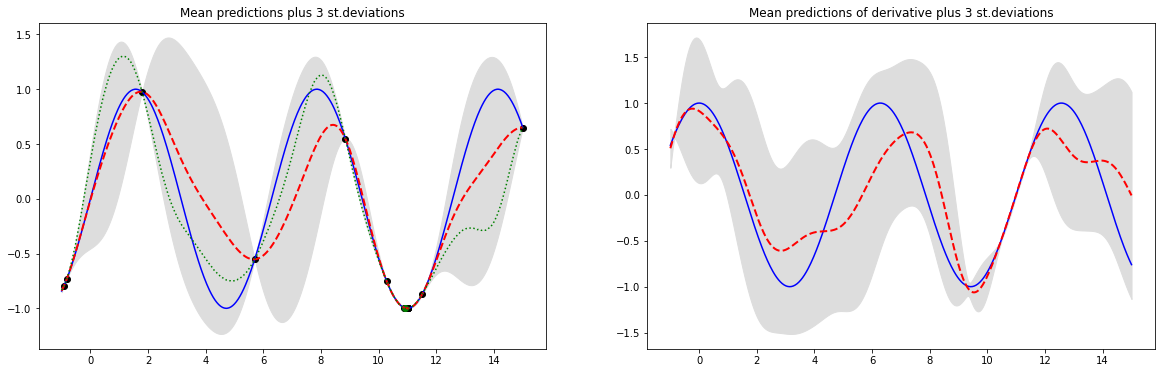

w:  [10.92785571]


In [22]:
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 40
history = []

w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    mu_grad = np.squeeze(mu_grad)
    s_grad = np.sqrt(np.diag(covar_grad))
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, dim)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'go')
    
    ax1.plot(Grid.flat, np.sin(Grid.flat), 'b-')
#     ax1.plot(Grid.flat, functions.Ackley_1().func(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(Grid, mu, 'r--', lw=2)
    ax1.plot(Grid.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
#     ax2.plot(Grid.flat, np.cos(Grid.flat) + 0.1, 'b-') 
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])
    
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

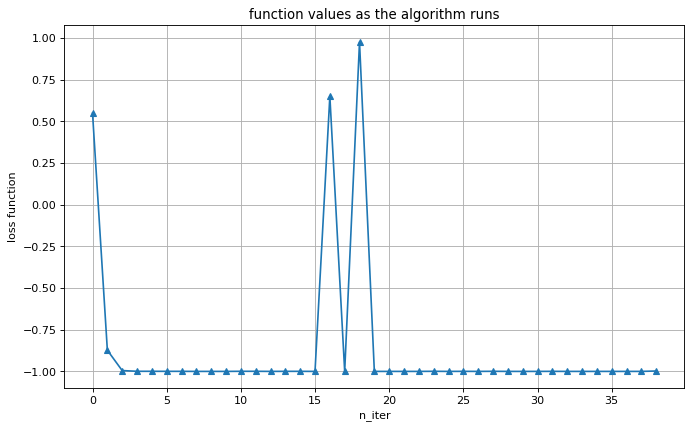

In [23]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [24]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# filenames = []
# for i in range(1, n_iter):
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     filenames.append(filename)

# frames=[]
# for filename in filenames:
#     frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'Ackley_noise.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)